# Prepare Data

In [16]:
import sys
sys.path.append('..')

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit
from scipy.stats import norm
from rouge_score import rouge_scorer, scoring
from pathlib import Path
import random

## Datasets

In [18]:
data_base_path = '../datasets'

merged_data_names = ['merged']
merged_split_names = ['train', 'validation', 'test']
merged_dataset_names = ['short', 'long', 'shortest', 'long_low_var']

gold_data_names = ['xsum', 'cnndm']
gold_split_names = ['train', 'validation', 'test']
gold_dataset_names = ['short', 'long', 'shortest', 'long_low_var', 'gold']

input_columns = ['article', 'document']
target_columns = ['summary', 'highlights']

In [19]:
merged_data = {}

for merged_data_name in merged_data_names:
    merged_data[merged_data_name] = {}
    
    for merged_split_name in merged_split_names:
        merged_data[merged_data_name][merged_split_name] = {}

        for merged_dataset_name in merged_dataset_names:
            merged_data[merged_data_name][merged_split_name][merged_dataset_name] = []
            
            jsonl_file_path = Path(data_base_path) / merged_data_name / merged_split_name / f"{merged_dataset_name}.jsonl"
            
            if not jsonl_file_path.exists():
                print(f"File {jsonl_file_path} does not exist.")
                continue  # Skip if file doesn't exist

            with jsonl_file_path.open('r', encoding='utf-8') as jsonl_file:
                for line in jsonl_file:
                    sample = json.loads(line)

                    data_obj = {
                        'input': "".join(sample.get(col, "") for col in input_columns),
                        'target': "".join(sample.get(col, "") for col in target_columns),
                    }
                    merged_data[merged_data_name][merged_split_name][merged_dataset_name].append(data_obj)

In [20]:
gold_data = {}

for gold_data_name in gold_data_names:
    gold_data[gold_data_name] = {}
    
    for gold_split_name in gold_split_names:
        gold_data[gold_data_name][gold_split_name] = {}

        for gold_dataset_name in gold_dataset_names:
            gold_data[gold_data_name][gold_split_name][gold_dataset_name] = []
            
            jsonl_file_path = Path(data_base_path) / gold_data_name / gold_split_name / f"{gold_dataset_name}.jsonl"
            
            if not jsonl_file_path.exists():
                print(f"File {jsonl_file_path} does not exist.")
                continue  # Skip if file doesn't exist

            with jsonl_file_path.open('r', encoding='utf-8') as jsonl_file:
                for line in jsonl_file:
                    sample = json.loads(line)

                    data_obj = {
                        'input': "".join(sample.get(col, "") for col in input_columns),
                        'target': "".join(sample.get(col, "") for col in target_columns),
                    }
                    gold_data[gold_data_name][gold_split_name][gold_dataset_name].append(data_obj)

File ../datasets/xsum/train/gold.jsonl does not exist.
File ../datasets/xsum/validation/gold.jsonl does not exist.
File ../datasets/cnndm/train/gold.jsonl does not exist.
File ../datasets/cnndm/validation/gold.jsonl does not exist.


## Generations

In [21]:
gen_base_path = '../experiments'

experiment_names = ['short_long', 'shortest_long', 'short_long_low_var']
variants = ['short', 'long', 'both']

merging_methods = ['linear', 'ties', 'dare_ties', 'dare_linear', 'cat']
interp_weights = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
extrap_amp_weights = [150, 140, 130, 120, 110]
extrap_deamp_weights = [-10, -20, -30, -40, -50]

In [22]:
gen_lens = {}

for experiment_name in experiment_names:
    gen_lens[experiment_name] = {}
    
    for variant in variants:
        gen_lens[experiment_name][variant] = {}
        
        all_weights = extrap_amp_weights + interp_weights + extrap_deamp_weights

        for merging_method in merging_methods:
            gen_lens[experiment_name][variant][merging_method] = {}

            for weight in all_weights:
                gen_lens[experiment_name][variant][merging_method][weight] = []

                gen_file_path = Path(gen_base_path) / "files" / f"{experiment_name}_{variant}" / merging_method / f"{weight}" / "cur_gen_lens.pkl"

                if not gen_file_path.exists():
                    gen_file_path_alt = Path(gen_base_path) / "files" / f"{experiment_name}_{variant}_keep" / merging_method / f"{weight}" / "cur_gen_lens.pkl"
                    if not gen_file_path_alt.exists():
                        print(f"File {gen_file_path} does not exist.")
                        continue
                    print(f"Using alternative (subset eval) for file {gen_file_path}!")
                    gen_file_path = gen_file_path_alt

                with gen_file_path.open('rb') as gen_file:
                    gen_len_list = pickle.load(gen_file)
                    gen_len_list = [x[0] for x in gen_len_list]
                
                gen_lens[experiment_name][variant][merging_method][weight] = gen_len_list

File ../experiments/files/short_long_short/linear/150/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/140/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/130/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/120/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/110/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/100/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/90/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/80/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/70/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/60/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linear/50/cur_gen_lens.pkl does not exist.
File ../experiments/files/short_long_short/linea

In [23]:
def extract_prompt(raw_text):
    return raw_text.split('<|start_header_id|>user<|end_header_id|>')[-1].split('<|start_header_id|>assistant<|end_header_id|>')[0].replace('<|eot_id|>', '').strip()

def extract_gen_or_target(raw_text):
    return raw_text.replace('<|eot_id|>', '').strip()

In [24]:
gens = {}

for experiment_name in experiment_names:
    gens[experiment_name] = {}
    
    for variant in variants:
        gens[experiment_name][variant] = {}
        
        all_weights = extrap_amp_weights + interp_weights + extrap_deamp_weights

        for merging_method in merging_methods:
            gens[experiment_name][variant][merging_method] = {}

            for weight in all_weights:
                gens[experiment_name][variant][merging_method][weight] = []

                gen_file_path = Path(gen_base_path) / "files" / f"{experiment_name}_{variant}" / merging_method / f"{weight}" / "ios.json"

                if not gen_file_path.exists():
                    gen_file_path_alt = Path(gen_base_path) / "files" / f"{experiment_name}_{variant}_keep" / merging_method / f"{weight}" / "ios.json"
                    if not gen_file_path_alt.exists():
                        print(f"File {gen_file_path} does not exist.")
                        continue
                    print(f"Using alternative (subset eval) for file {gen_file_path}!")
                    gen_file_path = gen_file_path_alt

                # read the json file
                with gen_file_path.open('r', encoding='utf-8') as gen_file:
                    gen_data = json.load(gen_file)

                gen_data = [
                    {
                        'prompt': extract_prompt(sample['prompt']),
                        'generated': extract_gen_or_target(sample['generated']),
                        'target': extract_gen_or_target(sample['target']),
                        'idx': sample['idx'],
                    }
                    for sample in gen_data
                ]
                
                gens[experiment_name][variant][merging_method][weight] = gen_data

File ../experiments/files/short_long_short/linear/150/ios.json does not exist.
File ../experiments/files/short_long_short/linear/140/ios.json does not exist.
File ../experiments/files/short_long_short/linear/130/ios.json does not exist.
File ../experiments/files/short_long_short/linear/120/ios.json does not exist.
File ../experiments/files/short_long_short/linear/110/ios.json does not exist.
File ../experiments/files/short_long_short/linear/100/ios.json does not exist.
File ../experiments/files/short_long_short/linear/90/ios.json does not exist.
File ../experiments/files/short_long_short/linear/80/ios.json does not exist.
File ../experiments/files/short_long_short/linear/70/ios.json does not exist.
File ../experiments/files/short_long_short/linear/60/ios.json does not exist.
File ../experiments/files/short_long_short/linear/50/ios.json does not exist.
File ../experiments/files/short_long_short/linear/40/ios.json does not exist.
File ../experiments/files/short_long_short/linear/30/ios.j

# Generation Length Evolution Plots

In [25]:
def get_mean(ls):
    return np.mean(np.array(ls))

def get_std(ls):
    return np.std(np.array(ls))

def remove_outliers(ls):
    mean = get_mean(ls)
    std = get_std(ls)
    z_score = np.abs((np.array(ls) - mean) / std)
    t = 4
    remove_count = len(z_score[z_score > t])
    print(f"Removing {remove_count} outliers.")
    print(f"the indices are {np.where(z_score > t)}")
    return np.array(ls)[z_score < t]

In [26]:
def update_evolution_plot(interp_len_data, extrap_amp_len_data, extrap_deamp_len_data, extrap, fig, ax, plt_idx, label_names):
    # Organize data
    if extrap:
        all_data = extrap_amp_len_data + interp_len_data + extrap_deamp_len_data
        all_weights = extrap_amp_weights + interp_weights + extrap_deamp_weights
        x_axis = np.array([w / 100 for w in all_weights])
    else:
        all_data = interp_len_data
        all_weights = interp_weights
        x_axis = np.array([w / 100 for w in all_weights])

    len_mean_data = np.array([get_mean(remove_outliers(len_data)) for len_data in all_data])
    len_std_data = np.array([get_std(remove_outliers(len_data)) for len_data in all_data])
    
    # Corrected Color Mapping (Extreme Ends Closer to Black)
    colors = ([(1 - i / (len(interp_weights) - 1), 0, i / (len(interp_weights) - 1)) for i in range(len(interp_weights) - 1)])
    if extrap:
        colors = (
            # from very dark red to red
            [(0.1 + 0.9 * i / (len(extrap_amp_weights) - 1), 0, 0) for i in range(len(extrap_amp_weights))]
            +
            # from red to blue
            [(1 - i / (len(interp_weights) - 1), 0, i / (len(interp_weights) - 1)) for i in range(len(interp_weights) - 1)]
            +
            # from blue to very dark blue (fixed: now fades to near black)
            [(0, 0.1 * (1 - i / (len(extrap_deamp_weights) - 1)), 0.1 + 0.9 * (1 - i / (len(extrap_deamp_weights) - 1))) for i in range(len(extrap_deamp_weights))]
        )

    # Line styles and transparency for extrapolation visibility
    if extrap:
        styles = ['dashed'] * len(extrap_amp_weights) + ['solid'] * (len(interp_weights) - 1) + ['dashed'] * len(extrap_deamp_weights)
        alphas = [0.5] * len(extrap_amp_weights) + [1.0] * (len(interp_weights) - 1) + [0.5] * len(extrap_deamp_weights)  # Faded extrapolation
    else:
        styles = ['solid'] * (len(interp_weights) - 1)
        alphas = [1.0] * (len(interp_weights) - 1)

    lin_width = 4

    for i in range(len(all_weights) - 1):
        ax.plot(
            x_axis[i:i+2],
            len_mean_data[i:i+2],
            linestyle=styles[i],
            color=colors[i],
            linewidth=lin_width,
            alpha=alphas[i]
        )

    lower_bound = len_mean_data - len_std_data
    upper_bound = len_mean_data + len_std_data
    ax.fill_between(x_axis, lower_bound, upper_bound, color='gray', alpha=0.1)

    markers = ['o', '*']
    sz = [150, 450]

    if plt_idx == 0 or label_names[plt_idx][0] != label_names[plt_idx - 1][0]:
        red_color = "red"
        if extrap:
            ax.scatter([x_axis[len(extrap_amp_weights)]], [len_mean_data[len(extrap_amp_weights)]], color=red_color, s=sz[plt_idx], label=label_names[plt_idx][0], zorder=5, marker=markers[plt_idx], edgecolors='white')
            ax.scatter([x_axis[len(extrap_amp_weights)]], [len_mean_data[len(extrap_amp_weights)]], color=red_color, s=sz[plt_idx], zorder=5, marker=markers[plt_idx], edgecolors='white')
        else:
            ax.scatter([x_axis[0]], [len_mean_data[0]], color=red_color, s=sz[plt_idx], label=label_names[plt_idx][0], zorder=5, marker=markers[plt_idx], edgecolors='white')
            ax.scatter([x_axis[0]], [len_mean_data[0]], color=red_color, s=sz[plt_idx], zorder=5, marker=markers[plt_idx], edgecolors='white')
    if plt_idx == 0 or label_names[plt_idx][1] != label_names[plt_idx - 1][1]:           
        blue_color = "blue"
        if extrap:
            ax.scatter([x_axis[-len(extrap_deamp_weights) - 1]], [len_mean_data[-len(extrap_deamp_weights)-1]], color=blue_color, s=sz[plt_idx], label=label_names[plt_idx][1], zorder=5, marker=markers[plt_idx], edgecolors='white')
            ax.scatter([x_axis[-len(extrap_deamp_weights) - 1]], [len_mean_data[-len(extrap_deamp_weights)-1]], color=blue_color, s=sz[plt_idx], zorder=5, marker=markers[plt_idx], edgecolors='white')
        else:
            ax.scatter([x_axis[-1]], [len_mean_data[-1]], color=blue_color, s=sz[plt_idx], label=label_names[plt_idx][1], zorder=5, marker=markers[plt_idx], edgecolors='white')
            ax.scatter([x_axis[-1]], [len_mean_data[-1]], color=blue_color, s=sz[plt_idx], zorder=5, marker=markers[plt_idx], edgecolors='white')

    # Legend for line types
    if plt_idx == len(label_names) - 1:
        ax.plot([], [], color='purple', linestyle='solid', label="Interpolation", linewidth=lin_width)
        if extrap:
            ax.plot([], [], color='darkred', linestyle='dashed', alpha=0.5, label="Extrapolation (Short)", linewidth=lin_width)
            ax.plot([], [], color='darkblue', linestyle='dashed', alpha=0.5, label="Extrapolation (Long)", linewidth=lin_width)

In [27]:
def plot_both_evolution(interp_len_datas, extrap_amp_len_datas, extrap_deamp_len_datas, extrap=True, label_names=[("Shorter Model", "Longer Model"), ("Shorter Model", "Longer Model")]):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    label_names = label_names[:len(interp_len_datas)]

    for i, (interp_len_data, extrap_amp_len_data, extrap_deamp_len_data) in enumerate(zip(interp_len_datas, extrap_amp_len_datas, extrap_deamp_len_datas)):
        update_evolution_plot(interp_len_data, extrap_amp_len_data, extrap_deamp_len_data, extrap, fig, ax, i, label_names)

    # Invert x-axis
    ax.invert_xaxis()

    # Labels and title
    ax.set_xlabel("Weight", fontsize=14)
    ax.set_ylabel("Mean Length", fontsize=14)
    ax.set_title("Evolution of Mean Length Across Weights", fontsize=20)

    # Display legend
    ax.legend(fontsize=14)

    plt.show()


In [28]:
def plot_only_evolution(all_data, is_shorter):
    # Organize data
    all_weights = extrap_amp_weights + interp_weights + extrap_deamp_weights
    x_axis = np.array([w / 100 for w in all_weights])
    
    len_mean_data = np.array([get_mean(remove_outliers(len_data)) for len_data in all_data])
    len_std_data = np.array([get_std(remove_outliers(len_data)) for len_data in all_data])
    
    if is_shorter:
        colors = (
            # from very dark red to red
            [(0.1 + 0.9 * i / (len(extrap_amp_weights) - 1), 0, 0) for i in range(len(extrap_amp_weights))]
            +
            # from red to white
            [(1, i / (len(interp_weights) - 1), i / (len(interp_weights) - 1)) for i in range(len(interp_weights) - 1)]
            +
            # from white to light blue
            [(1 - i / (len(extrap_deamp_weights) - 1) * 0.3,  # Red fades from 1 to 0.7
            1 - i / (len(extrap_deamp_weights) - 1) * 0.3,  # Green fades from 1 to 0.9
            1)  # Blue stays at 1
            for i in range(len(extrap_deamp_weights))]
        )
    else:
        colors = (
            # from very dark blue to blue
            [(0, 0, 0.1 + 0.9 * i / (len(extrap_amp_weights) - 1)) for i in range(len(extrap_amp_weights))]
            +
            # from blue to white
            [(i / (len(interp_weights) - 1), i / (len(interp_weights) - 1), 1) for i in range(len(interp_weights) - 1)]
            +
            # from white to light red
            [(1, 1 - i / (len(extrap_deamp_weights) - 1) * 0.3,  # Green fades slightly from 1 to 0.9
            1 - i / (len(extrap_deamp_weights) - 1) * 0.3)  # Blue fades from 1 to 0.7
            for i in range(len(extrap_deamp_weights))]
        )


    # Line styles and transparency for extrapolation visibility
    
    styles = ['dashed'] * (len(all_data) - 1)
    alphas = [1.0] * (len(all_data) - 1)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(len(all_weights) - 1):
        ax.plot(
            x_axis[i:i+2],
            len_mean_data[i:i+2],
            linestyle=styles[i],
            color=colors[i],
            linewidth=4,
            alpha=alphas[i]
        )

    lower_bound = len_mean_data - len_std_data
    upper_bound = len_mean_data + len_std_data
    ax.fill_between(x_axis, lower_bound, upper_bound, color='gray', alpha=0.1)

    # Invert x-axis
    if is_shorter:
        ax.invert_xaxis()

    # Add dots for short and long models with color-coded labels
    if is_shorter:
        ax.scatter([x_axis[len(extrap_amp_weights)]], [len_mean_data[len(extrap_amp_weights)]], color="red", s=150, label="Shorter Model", zorder=5, edgecolors='white')
    else:
        ax.scatter([x_axis[len(extrap_amp_weights)]], [len_mean_data[len(extrap_amp_weights)]], color="blue", s=150, label="Longer Model", zorder=5, edgecolors='white')
    
    ax.scatter([x_axis[-len(extrap_deamp_weights)-1]], [len_mean_data[-len(extrap_deamp_weights)-1]], color="white", s=150, label="Base Model", zorder=5, edgecolors='black', linewidth=1)


    # Legend for line types
    if is_shorter:
        ax.plot([], [], color=(
            0.7, 0.7, 0.7
        ), linestyle='dashed', label="Extrapolation", linewidth=4)
    else:
        ax.plot([], [], color=(
            0.7, 0.7, 0.7
        ), linestyle='dashed', label="Extrapolation", linewidth=4)

    # Labels and title
    ax.set_xlabel("Weight", fontsize=16)
    ax.set_ylabel("Mean Length", fontsize=16)
    ax.set_title("Evolution of Mean Length Across Weights", fontsize=24)

    # Display legend
    ax.legend(fontsize=16)

    plt.show()


## Short - Long

### Linear (extrap)

Removing 3 outliers.
the indices are (array([ 11,  85, 200]),)
Removing 1 outliers.
the indices are (array([426]),)
Removing 5 outliers.
the indices are (array([ 18,  25, 141, 151, 397]),)
Removing 3 outliers.
the indices are (array([ 81, 161, 476]),)
Removing 2 outliers.
the indices are (array([673, 694]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]),)
Removing 3 outliers.
the indices are (array([ 62, 617, 628]),)
Removing 1 outliers.
the indices are (array([640]),)
Removing 1 outliers.
the indices are (array([165]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 5 outliers.
the indices are (array([ 72, 131, 216, 678, 704]),)

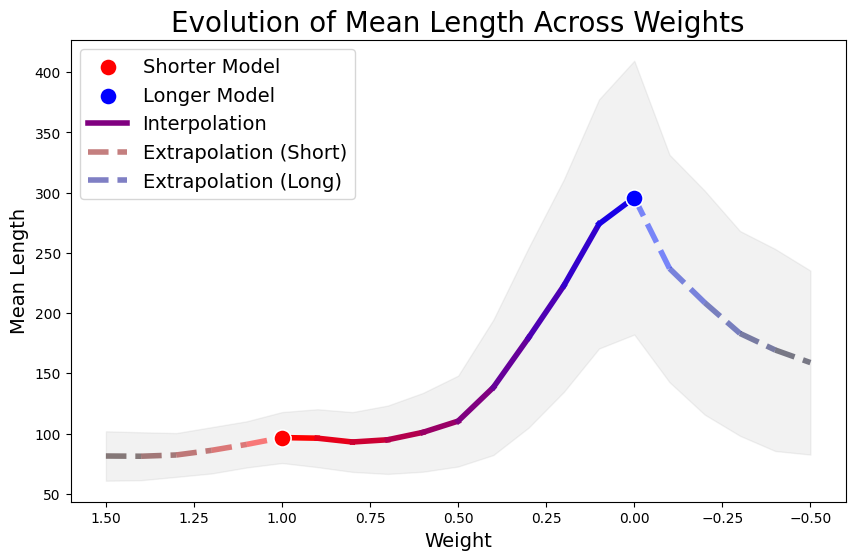

In [29]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_amp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_deamp_weights
    ]]
)

### Linear

Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]),)
Removing 3 outliers.
the indices are (array([ 62, 617, 628]),)
Removing 1 outliers.
the indices are (array([640]),)
Removing 1 outliers.
the indices are (array([165]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]

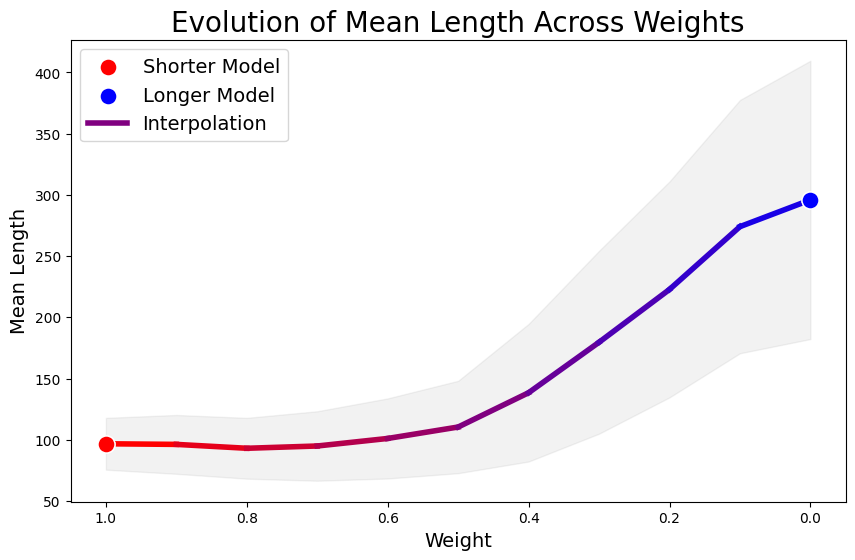

In [30]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_amp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_deamp_weights
    ]],
    extrap=False
)

### TIES

Removing 1 outliers.
the indices are (array([234]),)
Removing 3 outliers.
the indices are (array([ 15, 215, 705]),)
Removing 1 outliers.
the indices are (array([215]),)
Removing 5 outliers.
the indices are (array([ 11,  15, 491, 547, 585]),)
Removing 5 outliers.
the indices are (array([ 11,  15, 215, 287, 369]),)
Removing 4 outliers.
the indices are (array([ 15,  88,  94, 427]),)
Removing 2 outliers.
the indices are (array([ 11, 531]),)
Removing 3 outliers.
the indices are (array([572, 585, 617]),)
Removing 3 outliers.
the indices are (array([ 21, 585, 646]),)
Removing 5 outliers.
the indices are (array([ 11, 203, 295, 491, 705]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 3 outliers.
the indices are (array([ 15, 215, 705]),)
Removing 1 outliers.
the indices are (array([215]),)
Removing 5 outliers.
the indices are (array([ 11,  15, 491, 547, 585]),)
Removing 5 outliers.
the indices are (array([ 11,  15, 

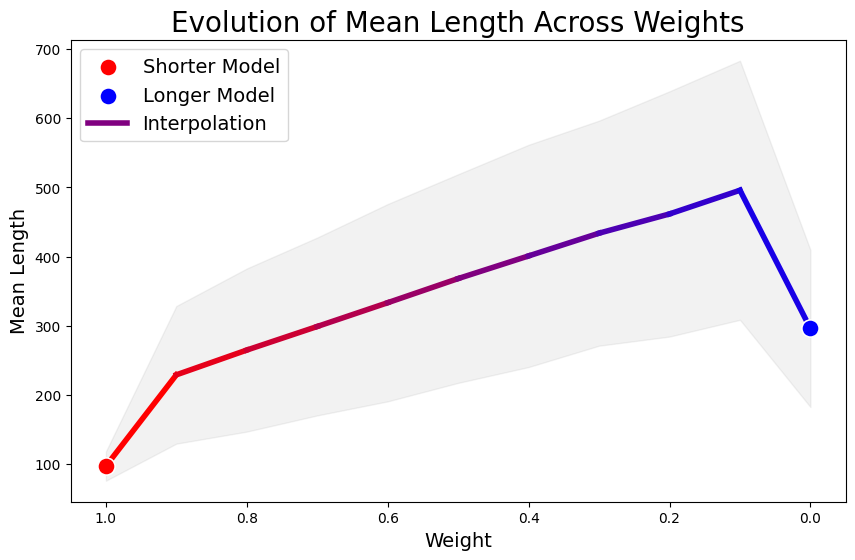

In [31]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['ties'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['ties'][weight]
        for weight in extrap_amp_weights
    ]],
    [[
        gen_lens['short_long']['both']['ties'][weight]
        for weight in extrap_deamp_weights
    ]],
    extrap=False
)

### Dare Linear

Removing 1 outliers.
the indices are (array([234]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([325]),)
Removing 1 outliers.
the indices are (array([628]),)
Removing 1 outliers.
the indices are (array([729]),)
Removing 1 outliers.
the indices are (array([203]),)
Removing 3 outliers.
the indices are (array([ 21, 356, 569]),)
Removing 4 outliers.
the indices are (array([215, 356, 369, 505]),)
Removing 2 outliers.
the indices are (array([572, 654]),)
Removing 4 outliers.
the indices are (array([115, 304, 513, 617]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([325]),)
Removing 1 outliers.
the indices are (array([628]),)
Removing 1 outliers.
the indices are (array([729]),)
Removing 1 outliers.
the indices are (array([203]),)
Removing 3 outliers.
the

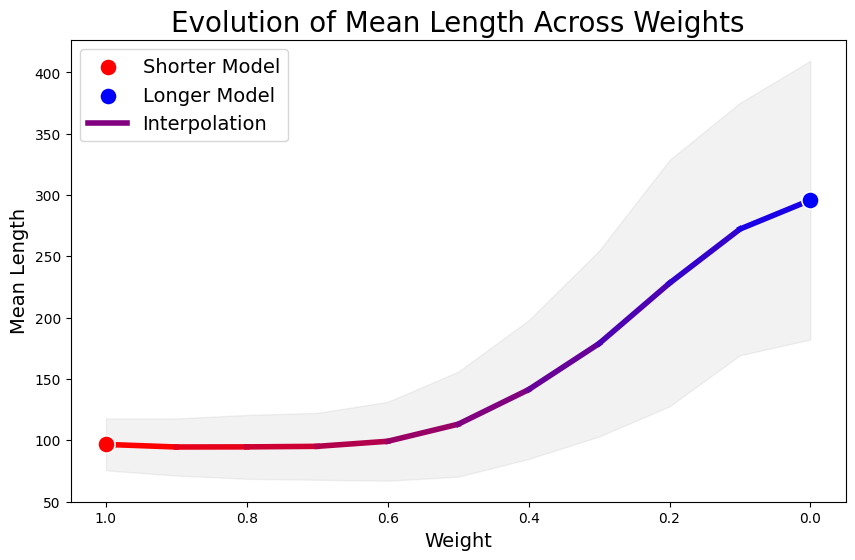

In [32]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['dare_linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['dare_linear'][weight]
        for weight in extrap_amp_weights
    ]],
    [[
        gen_lens['short_long']['both']['dare_linear'][weight]
        for weight in extrap_deamp_weights
    ]],
    extrap=False
)

### Dare TIES

Removing 1 outliers.
the indices are (array([234]),)
Removing 3 outliers.
the indices are (array([ 11, 203, 729]),)
Removing 4 outliers.
the indices are (array([ 15, 215, 332, 705]),)
Removing 3 outliers.
the indices are (array([11, 15, 45]),)
Removing 3 outliers.
the indices are (array([ 38,  72, 295]),)
Removing 4 outliers.
the indices are (array([ 11, 491, 652, 705]),)
Removing 7 outliers.
the indices are (array([ 11,  15,  94, 273, 491, 547, 673]),)
Removing 4 outliers.
the indices are (array([ 11,  15,  29, 694]),)
Removing 5 outliers.
the indices are (array([ 15,  72, 547, 599, 617]),)
Removing 4 outliers.
the indices are (array([225, 547, 585, 710]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 3 outliers.
the indices are (array([ 11, 203, 729]),)
Removing 4 outliers.
the indices are (array([ 15, 215, 332, 705]),)
Removing 3 outliers.
the indices are (array([11, 15, 45]),)
Removing 3 outliers.
the i

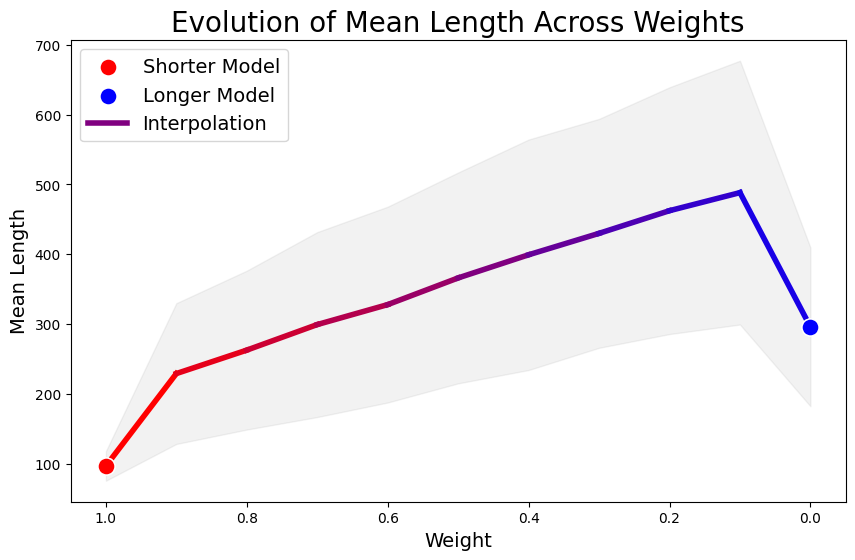

In [33]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['dare_ties'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['dare_ties'][weight]
        for weight in extrap_amp_weights
    ]],
    [[
        gen_lens['short_long']['both']['dare_ties'][weight]
        for weight in extrap_deamp_weights
    ]],
    extrap=False
)

### Cat

Removing 1 outliers.
the indices are (array([234]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([704]),)
Removing 1 outliers.
the indices are (array([230]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([369]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([21]),)
Removing 3 outliers.
the indices are (array([120, 287, 678]),)
Removing 1 outliers.
the indices are (array([572]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([704]),)
Removing 1 outliers.
the indices are (array([230]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([369]),)
Removing 0 outliers.
the indic

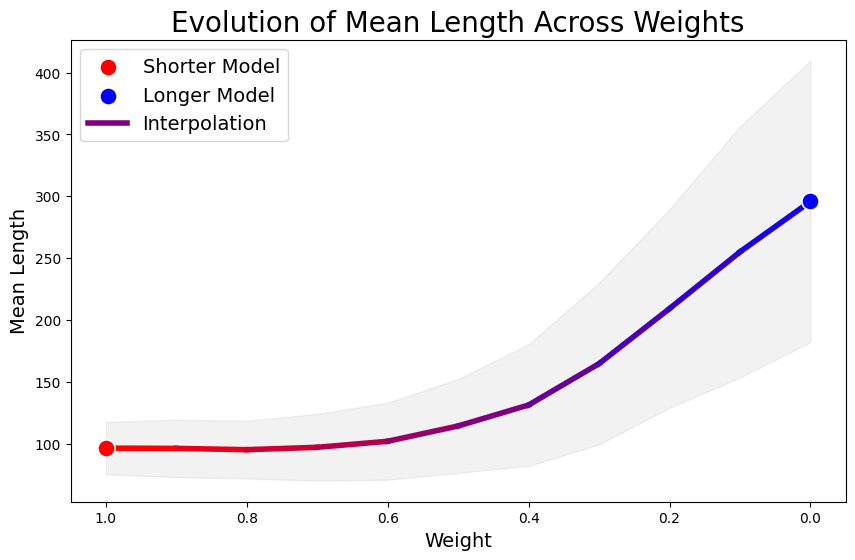

In [34]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['cat'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['cat'][weight]
        for weight in extrap_amp_weights
    ]],
    [[
        gen_lens['short_long']['both']['cat'][weight]
        for weight in extrap_deamp_weights
    ]],
    extrap=False
)

## Shortest - Long (together with linear)

Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]),)
Removing 3 outliers.
the indices are (array([ 62, 617, 628]),)
Removing 1 outliers.
the indices are (array([640]),)
Removing 1 outliers.
the indices are (array([165]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]

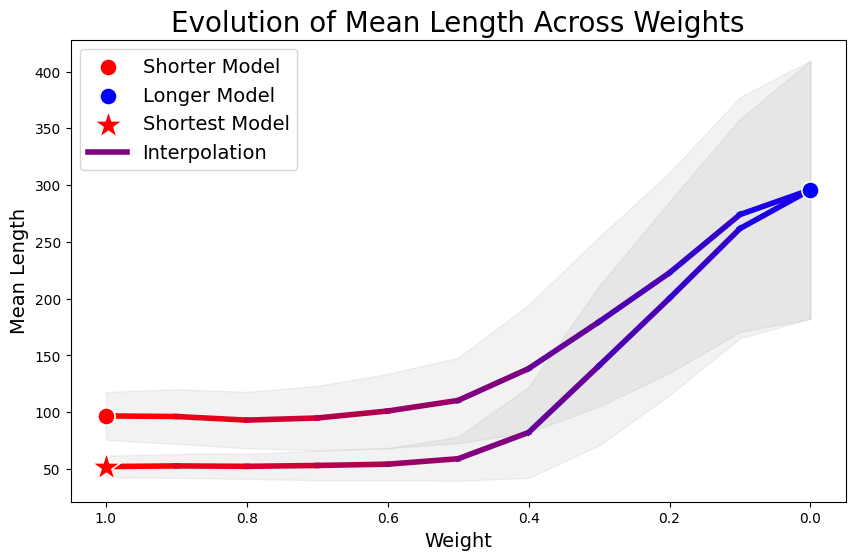

In [35]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in interp_weights
    ],
    [
        gen_lens['shortest_long']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_amp_weights
    ],
    [
        gen_lens['shortest_long']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_deamp_weights
    ],
    [
        gen_lens['shortest_long']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    extrap=False,
    label_names=[("Shorter Model", "Longer Model"), ("Shortest Model", "Longer Model")]
)

## Short - Long (low var) (with Linear)

Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]),)
Removing 3 outliers.
the indices are (array([ 62, 617, 628]),)
Removing 1 outliers.
the indices are (array([640]),)
Removing 1 outliers.
the indices are (array([165]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]

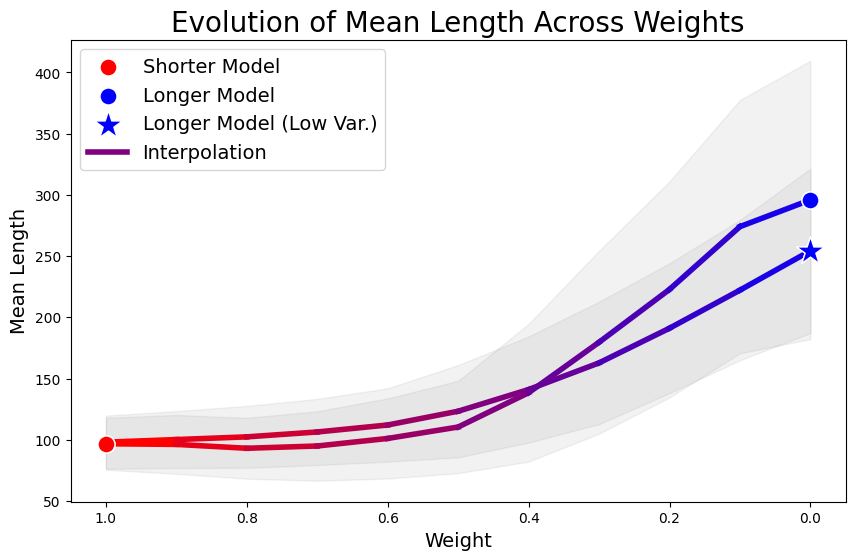

In [36]:
plot_both_evolution(
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in interp_weights
    ],
    [
        gen_lens['short_long_low_var']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_amp_weights
    ],
    [
        gen_lens['short_long_low_var']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    [[
        gen_lens['short_long']['both']['linear'][weight]
        for weight in extrap_deamp_weights
    ],
    [
        gen_lens['short_long_low_var']['both']['linear'][weight]
        for weight in interp_weights
    ]],
    extrap=False,
    label_names=[("Shorter Model", "Longer Model"), ("Shorter Model", "Longer Model (Low Var.)")]
)

# Generation Length Distribution Plots

In [37]:
# Define Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Fit Gaussian function with error estimation
def fit_gaussian(data):
    mu, std = norm.fit(data)  # Get mean and std from raw data
    hist, bin_edges = np.histogram(data, bins=30, density=True)  # Get histogram
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Fit using curve_fit
    try:
        popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[mu, std, max(hist)])
    except RuntimeError:
        popt = [mu, std, max(hist)]  # Fallback in case of failure

    return popt, bin_centers, hist

In [38]:
def plot_dist_for_method(len_lists, weights):

    # from red to blue
    colors = [
        (1 - i / (len(len_lists) - 1), 0, i / (len(len_lists) - 1))
        for i in range(len(len_lists))
    ]

    xlim = 550

    # Initialize figure
    plt.figure(figsize=(10, 6))

    # Define models
    model_names_list = ['Short Model'] + [f'Weighted Model w={w/100}' for w in weights[1:-1]] + ['Long Model']
    model_np_list = np.array(len_lists)
    bins = [50] * len(model_np_list)

    # Plot distributions
    for model_name, model_np, color, bin_size in zip(model_names_list, model_np_list, colors, bins):
        gaussian_params = fit_gaussian(model_np)[0]

        # Histogram
        plt.hist(model_np, bins=bin_size, density=True, alpha=0.3, color=color, label=model_name, edgecolor="black", linewidth=0.5)

        # Gaussian Fit Curve (MATCHES histogram color)
        x_range = np.linspace(0, xlim, 1000)
        plt.plot(x_range, gaussian(x_range, *gaussian_params), linestyle="--", color=color, linewidth=3, alpha=1)

    # Labels and Title
    plt.xlabel("Generated Summary Lengths", fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.title("Summary Length Distribution Across Different Models", fontsize=24)

    # Grid for better visibility
    # plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Legend improvement
    plt.legend(fontsize=16)

    # Limit x-axis
    plt.xlim(0, xlim)

    # Show plot
    plt.show()


## Short - Long

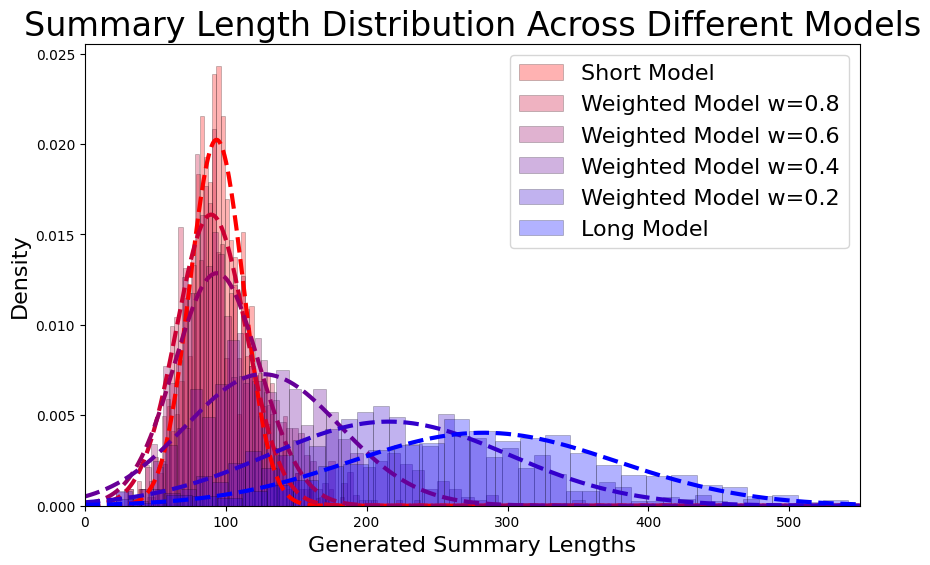

In [39]:
plot_dist_for_method(
    [
        gen_lens['short_long']['both']['linear'][weight]
        for weight in interp_weights[::2]
    ],
    interp_weights[::2]
)

# Dataset Length Distribution Plots

In [40]:
def plot_datasets_len_distributions(data_lists, data_labels, colors, alphas=None, which='target'):
    plt.figure(figsize=(10, 6))

    if alphas is None:
        alphas = [0.8] * len(data_lists)

    for data_list, data_label, color, alpha in zip(data_lists, data_labels, colors, alphas):
        lens = np.array([len(sample[which]) for sample in data_list])
        plt.hist(lens, bins=25, alpha=alpha, color=color, label=data_label, edgecolor='black', zorder=100)
    

    if which == 'target':
        plt.xlabel('Target Summary Length', fontsize=16)
        plt.title('Target Summary Length Distribution Across Divisions', fontsize=24)
    elif which == 'input':
        plt.xlabel('Input Length', fontsize=16)
        plt.title('Input Length Distribution Across Divisions', fontsize=24)
    else:
        raise ValueError("Invalid 'which' parameter.")

    plt.ylabel('Count', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()


## Test

### Short - Long

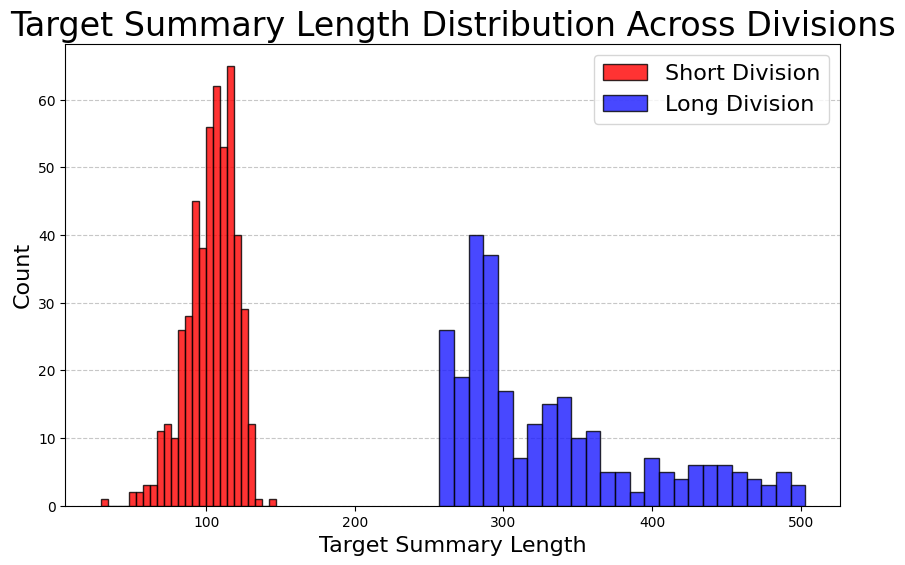

In [41]:
from matplotlib.colors import hsv_to_rgb
plot_datasets_len_distributions(
    [
        merged_data['merged']['test']['short'],
        merged_data['merged']['test']['long'],
    ],
    ['Short Division', 'Long Division'],
    [(1, 0, 0), (0.1, 0.1, 1)]
)

### Shortest - Long

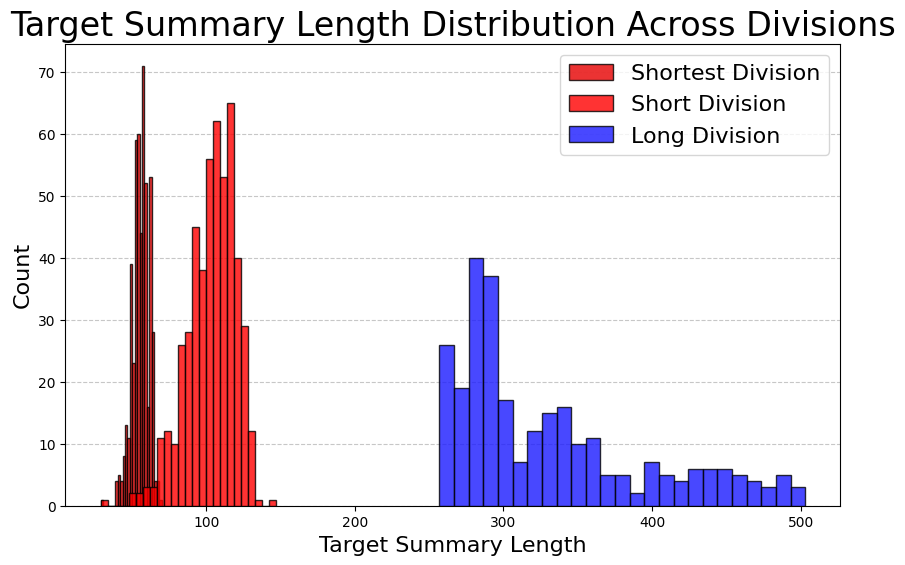

In [42]:
plot_datasets_len_distributions(
    [
        merged_data['merged']['test']['shortest'],
        merged_data['merged']['test']['short'],
        merged_data['merged']['test']['long'],
    ],
    ['Shortest Division', 'Short Division', 'Long Division'],
    [(0.9, 0, 0), (1, 0, 0), (0.1, 0.1, 1)],
)

### Short - Long (low var)

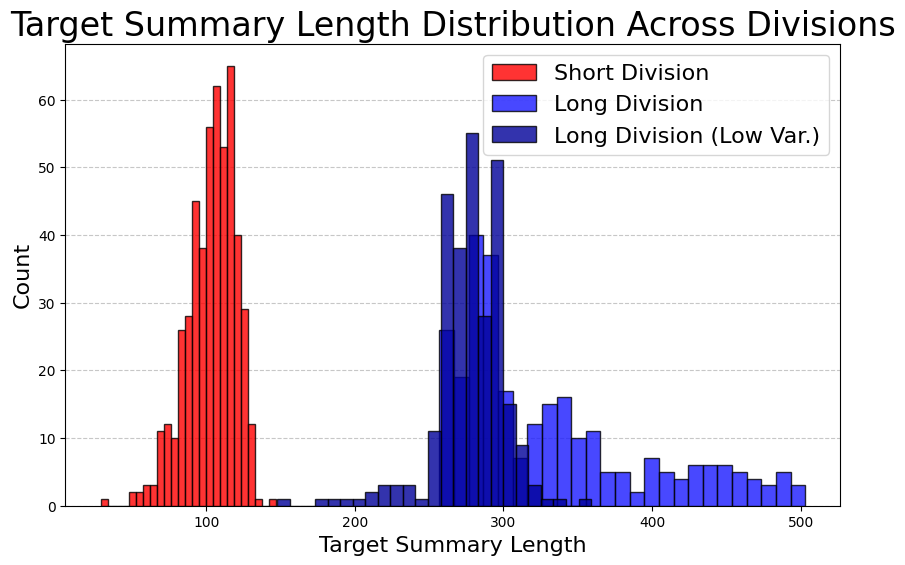

In [43]:
plot_datasets_len_distributions(
    [
        merged_data['merged']['test']['short'],
        merged_data['merged']['test']['long'],
        merged_data['merged']['test']['long_low_var'],
    ],
    ['Short Division', 'Long Division', 'Long Division (Low Var.)'],
    [(1, 0, 0), (0.1, 0.1, 1), (0, 0, 0.6)],
)

# Rouge Evals (Combined Test Set)

In [44]:
def compute_rouge_for_a_model(gen_ref_data):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()

    for gen, ref in gen_ref_data:
        scores = scorer.score(gen, ref)
        aggregator.add_scores(scores)

    result = aggregator.aggregate()
    return result

In [45]:
def plot_both_rouge(interp_gen_ref_data, extrap_amp_gen_ref_data, extrap_deamp_gen_ref_data, extrap=True):
    # Organize data
    if extrap:
        all_data = extrap_amp_gen_ref_data + interp_gen_ref_data + extrap_deamp_gen_ref_data
        all_weights = extrap_amp_weights + interp_weights + extrap_deamp_weights
        x_axis = np.array([w / 100 for w in all_weights])
    else:
        all_data = interp_gen_ref_data
        all_weights = interp_weights
        x_axis = np.array([w / 100 for w in all_weights])

    rouge_scores = np.array([compute_rouge_for_a_model(gen_ref_data) for gen_ref_data in all_data])
    rouge1_f1_scores = np.array([score['rouge1'].mid.fmeasure for score in rouge_scores])
    rouge2_f1_scores = np.array([score['rouge2'].mid.fmeasure for score in rouge_scores])
    rougeL_f1_scores = np.array([score['rougeL'].mid.fmeasure for score in rouge_scores])

    colors = ['orange', 'green', 'purple']

    # Line styles and transparency for extrapolation visibility
    if extrap:
        styles = ['dashed'] * len(extrap_amp_weights) + ['solid'] * (len(interp_weights) - 1) + ['dashed'] * len(extrap_deamp_weights)
        alphas = [0.5] * len(extrap_amp_weights) + [1.0] * (len(interp_weights) - 1) + [0.5] * len(extrap_deamp_weights)  # Faded extrapolation
    else:
        styles = ['solid'] * (len(interp_weights) - 1)
        alphas = [1.0] * (len(interp_weights) - 1)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.tight_layout()

    for j, plot_data in enumerate([rouge1_f1_scores, rouge2_f1_scores, rougeL_f1_scores]):
        for i in range(len(all_weights) - 1):
            ax.plot(
                x_axis[i:i+2],
                plot_data[i:i+2],
                linestyle=styles[i],
                color=colors[j],
                linewidth=4,
                alpha=alphas[i]
            )

    # Invert x-axis
    ax.invert_xaxis()

    # Legend for line types
    ax.plot([], [], color='darkgray', linestyle='solid', label="Interpolation", linewidth=4)
    if extrap:
        ax.plot([], [], color='darkgray', linestyle='dashed', alpha=0.5, label="Extrapolation", linewidth=4)

    # Legends for scores
    ax.plot([], [], color=colors[0], linestyle='solid', label="ROUGE-1", linewidth=4)
    ax.plot([], [], color=colors[1], linestyle='solid', label="ROUGE-2", linewidth=4)
    ax.plot([], [], color=colors[2], linestyle='solid', label="ROUGE-L", linewidth=4)

    # Labels and title
    ax.set_xlabel("Weight", fontsize=16)
    ax.set_ylabel("ROUGE Score", fontsize=16)
    ax.set_title("ROUGE Score Trends Across Different Weights", fontsize=24)

    # Display legend
    ax.legend(fontsize=16)

    plt.show()

    # print results for short and long models
    if extrap:
        offset_short = len(extrap_amp_weights)
        offset_long = -len(extrap_deamp_weights) - 1
    else:
        offset_short = 0
        offset_long = -1
    print("Shorter Model")
    print(f'Rouge-1: {rouge_scores[offset_short]["rouge1"].mid.fmeasure}')
    print(f'Rouge-2: {rouge_scores[offset_short]["rouge2"].mid.fmeasure}')
    print(f'Rouge-L: {rouge_scores[offset_short]["rougeL"].mid.fmeasure}')
    print("Longer Model")
    print(f'Rouge-1: {rouge_scores[offset_long]["rouge1"].mid.fmeasure}')
    print(f'Rouge-2: {rouge_scores[offset_long]["rouge2"].mid.fmeasure}')
    print(f'Rouge-L: {rouge_scores[offset_long]["rougeL"].mid.fmeasure}')


In [46]:
def plot_only_rouge(all_data, is_shorter):
    # Organize data
    
    all_weights = extrap_amp_weights + interp_weights + extrap_deamp_weights
    x_axis = np.array([w / 100 for w in all_weights])
    
    rouge_scores = np.array([compute_rouge_for_a_model(gen_ref_data) for gen_ref_data in all_data])
    rouge1_f1_scores = np.array([score['rouge1'].mid.fmeasure for score in rouge_scores])
    rouge2_f1_scores = np.array([score['rouge2'].mid.fmeasure for score in rouge_scores])
    rougeL_f1_scores = np.array([score['rougeL'].mid.fmeasure for score in rouge_scores])

    colors = ['orange', 'green', 'purple']

    # Line styles and transparency for extrapolation visibility
    styles = ['dashed'] * (len(all_data) - 1)
    alphas = [0.5] * (len(all_data) - 1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.tight_layout()

    for j, plot_data in enumerate([rouge1_f1_scores, rouge2_f1_scores, rougeL_f1_scores]):
        for i in range(len(all_weights) - 1):
            ax.plot(
                x_axis[i:i+2],
                plot_data[i:i+2],
                linestyle=styles[i],
                color=colors[j],
                linewidth=2,
                alpha=alphas[i]
            )

    # Invert x-axis
    if is_shorter:
        ax.invert_xaxis()

    # Legend for line types
    ax.plot([], [], color='darkgray', linestyle='dashed', alpha=0.5, label="Extrapolation", linewidth=4)

    # Legends for scores
    ax.plot([], [], color=colors[0], linestyle='solid', label="ROUGE-1", linewidth=4)
    ax.plot([], [], color=colors[1], linestyle='solid', label="ROUGE-2", linewidth=4)
    ax.plot([], [], color=colors[2], linestyle='solid', label="ROUGE-L", linewidth=4)

    # Labels and title
    ax.set_xlabel("Weight", fontsize=16)
    ax.set_ylabel("ROUGE Score", fontsize=16)
    ax.set_title("ROUGE Score Trends Across Different Weights", fontsize=24)

    # Display legend
    ax.legend(fontsize=16)

    plt.show()

## Combined Test Set

### Short - Long (extrap)

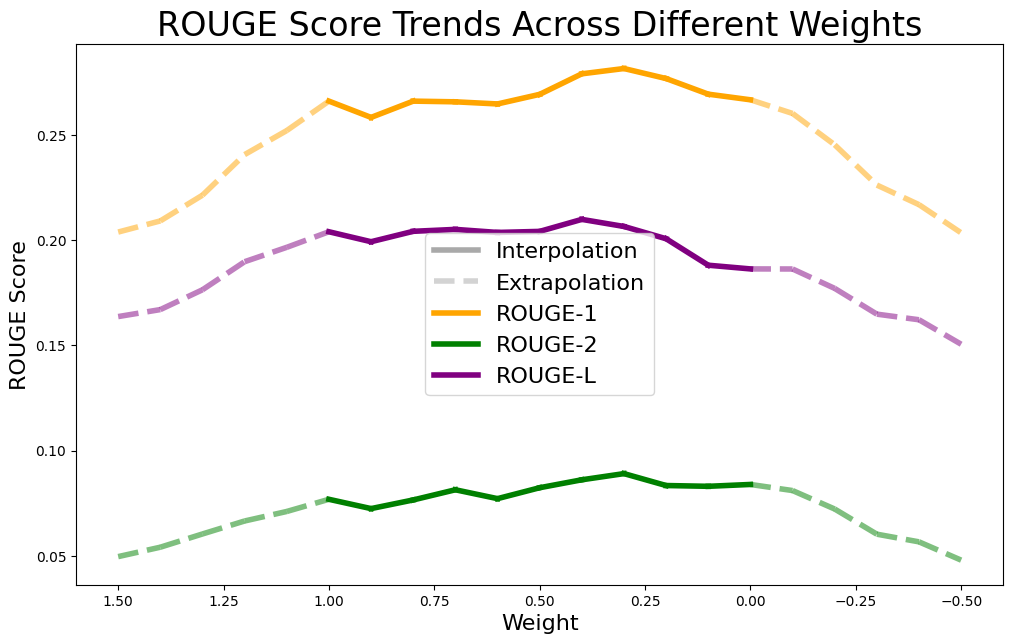

Shorter Model
Rouge-1: 0.26628041158524646
Rouge-2: 0.07680847872640992
Rouge-L: 0.20411906608886798
Longer Model
Rouge-1: 0.2669081479734178
Rouge-2: 0.08387231888415732
Rouge-L: 0.18643490771765406


In [47]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ]
)

### Short - Long

#### Linear

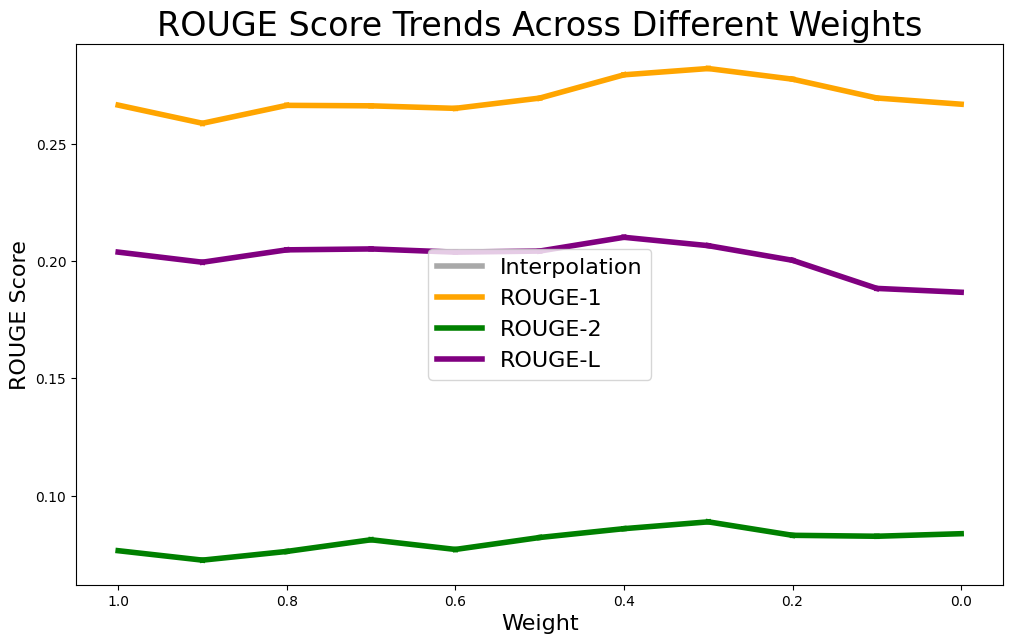

Shorter Model
Rouge-1: 0.2664081519305219
Rouge-2: 0.07661414744075716
Rouge-L: 0.20379017179951534
Longer Model
Rouge-1: 0.2667871982131843
Rouge-2: 0.08385161419256643
Rouge-L: 0.18668769889444808


In [48]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### TIES

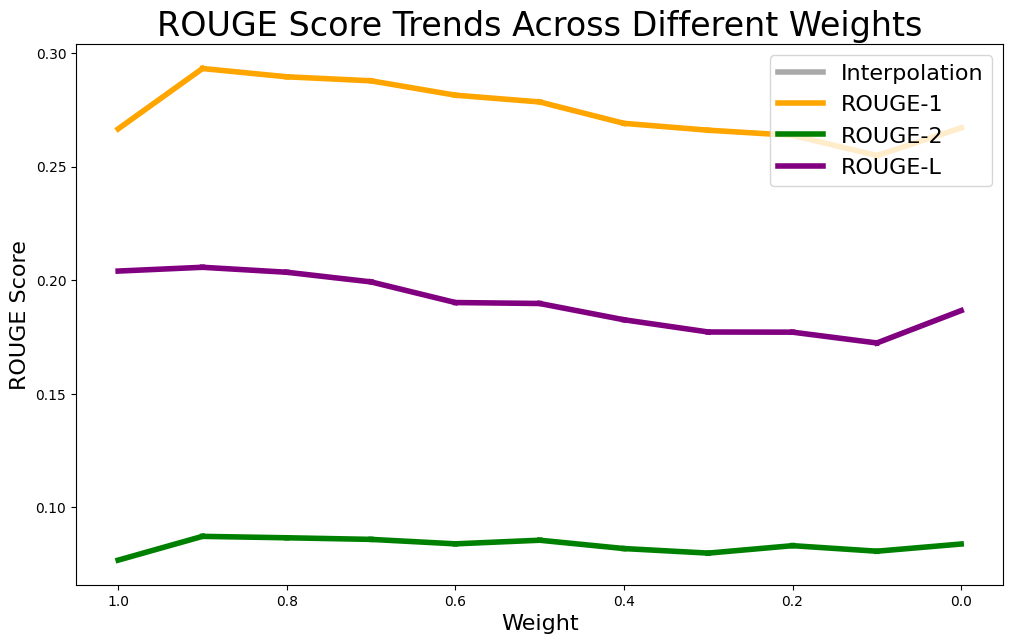

Shorter Model
Rouge-1: 0.26657376708741254
Rouge-2: 0.07673177706266929
Rouge-L: 0.20398730061769427
Longer Model
Rouge-1: 0.26702657653357764
Rouge-2: 0.08383284078439471
Rouge-L: 0.18659329189317417


In [49]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['ties'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['ties'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['ties'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Dare (Linear)

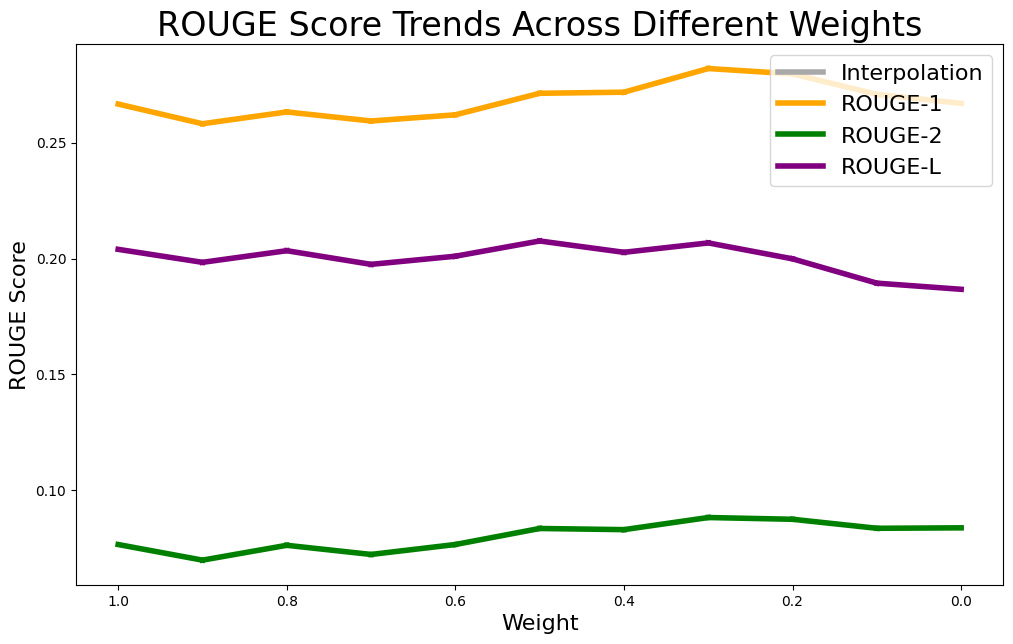

Shorter Model
Rouge-1: 0.26661926856358453
Rouge-2: 0.07664031830318738
Rouge-L: 0.2039538025690228
Longer Model
Rouge-1: 0.26689626429127605
Rouge-2: 0.08383864016452847
Rouge-L: 0.18672164725111312


In [50]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['dare_linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['dare_linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['dare_linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Dare (TIES)

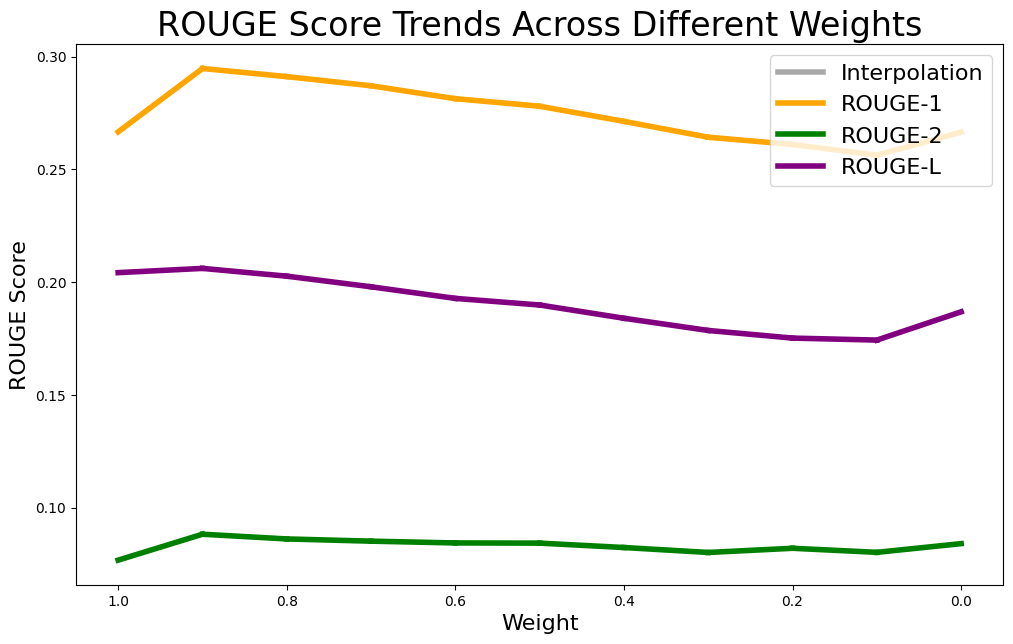

Shorter Model
Rouge-1: 0.26657192814962094
Rouge-2: 0.07665620995340958
Rouge-L: 0.2041482258506859
Longer Model
Rouge-1: 0.26646596190751887
Rouge-2: 0.08397900646660143
Rouge-L: 0.18678618301193461


In [51]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['dare_ties'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['dare_ties'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['dare_ties'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Cat

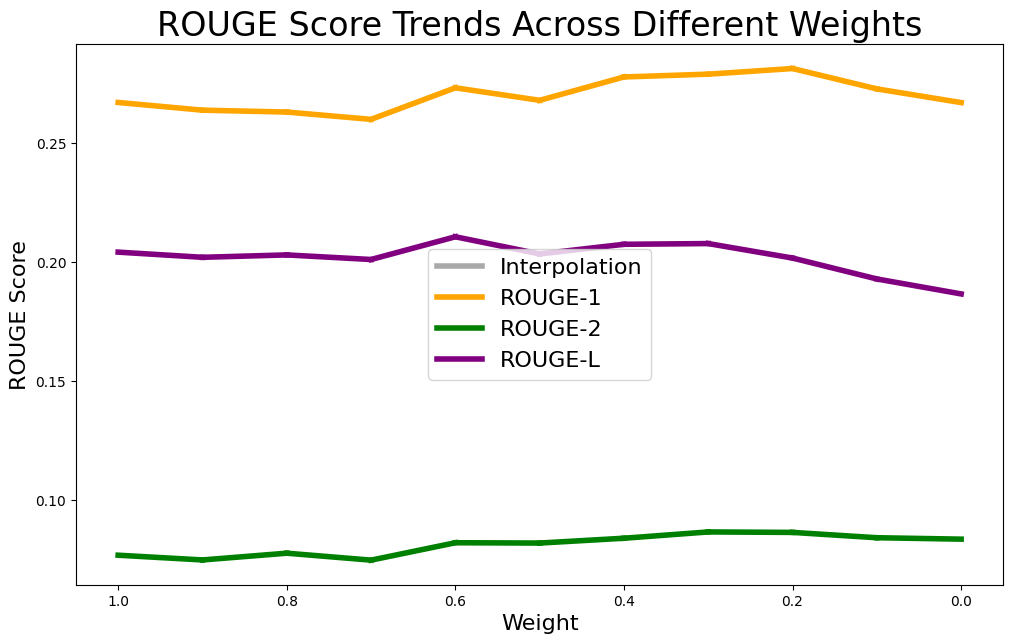

Shorter Model
Rouge-1: 0.26684762991636346
Rouge-2: 0.07692990007850245
Rouge-L: 0.2040691228638507
Longer Model
Rouge-1: 0.2667990075120724
Rouge-2: 0.08366497630718378
Rouge-L: 0.18653222254984214


In [52]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['cat'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['cat'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['cat'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Shortest - Long

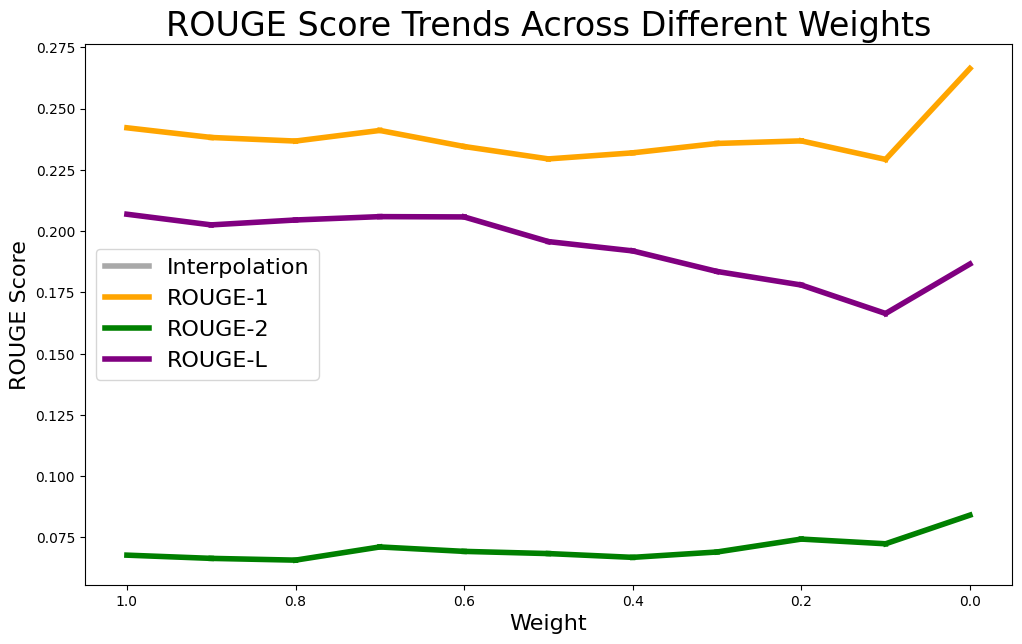

Shorter Model
Rouge-1: 0.24216931113348864
Rouge-2: 0.0677779744620464
Rouge-L: 0.2068981001545768
Longer Model
Rouge-1: 0.2663519516262871
Rouge-2: 0.08410465061283981
Rouge-L: 0.186573921658627


In [53]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Short - Long (low var)

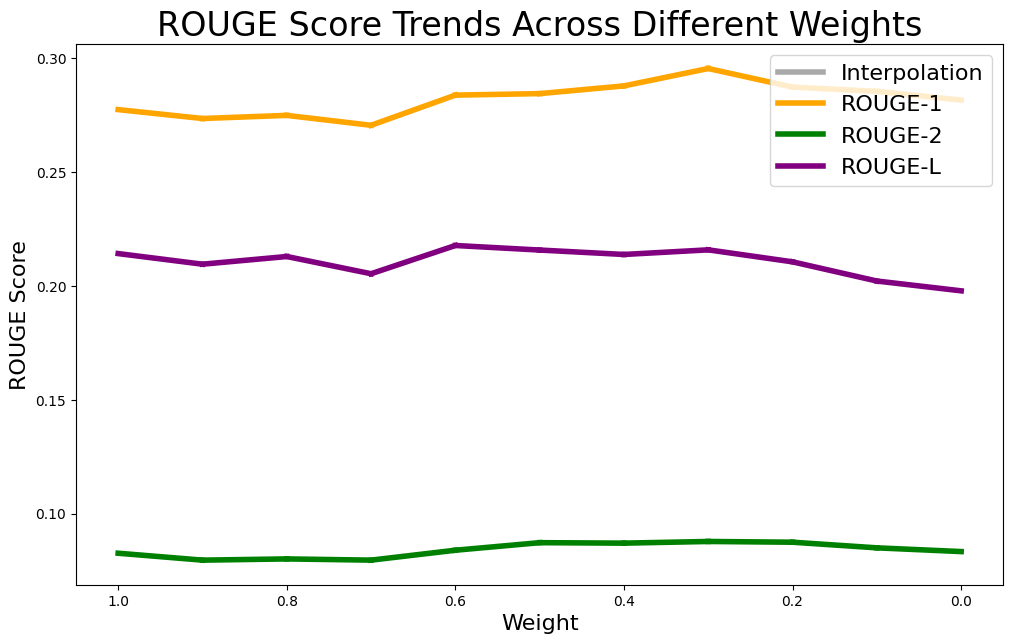

Shorter Model
Rouge-1: 0.2775285999713366
Rouge-2: 0.08257329910265998
Rouge-L: 0.21425894325420497
Longer Model
Rouge-1: 0.28170402215609636
Rouge-2: 0.08329870636326572
Rouge-L: 0.19788735720510883


In [54]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

## Shorter Test Set

### Short - Long (extrap)

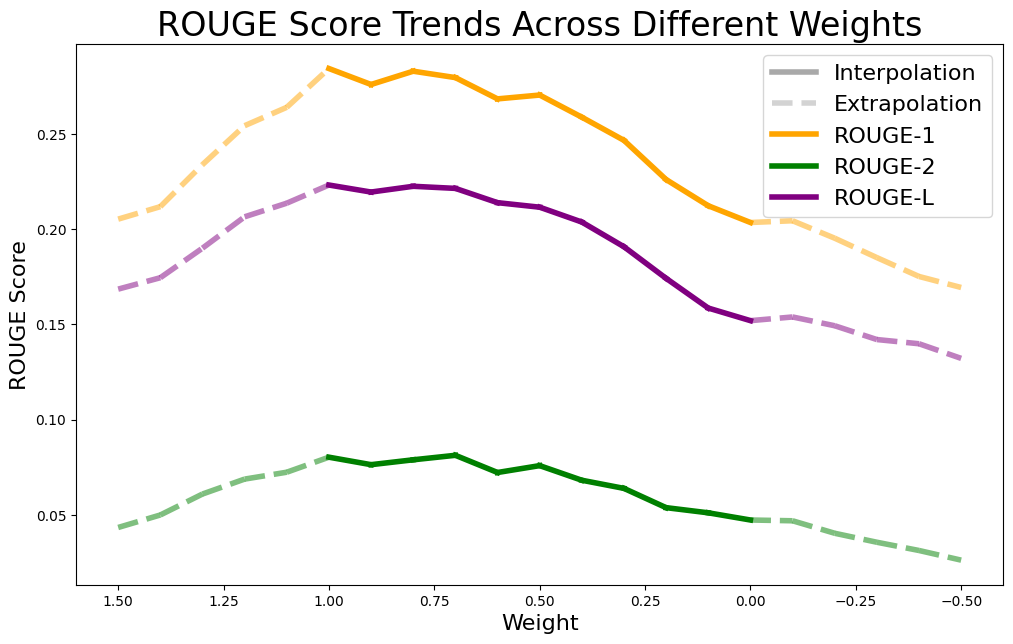

Shorter Model
Rouge-1: 0.28428841524282794
Rouge-2: 0.08026381719852985
Rouge-L: 0.22313362533182737
Longer Model
Rouge-1: 0.20346261510333985
Rouge-2: 0.04728796649190847
Rouge-L: 0.15193947787107498


In [55]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_deamp_weights
    ]
)

### Short - Long

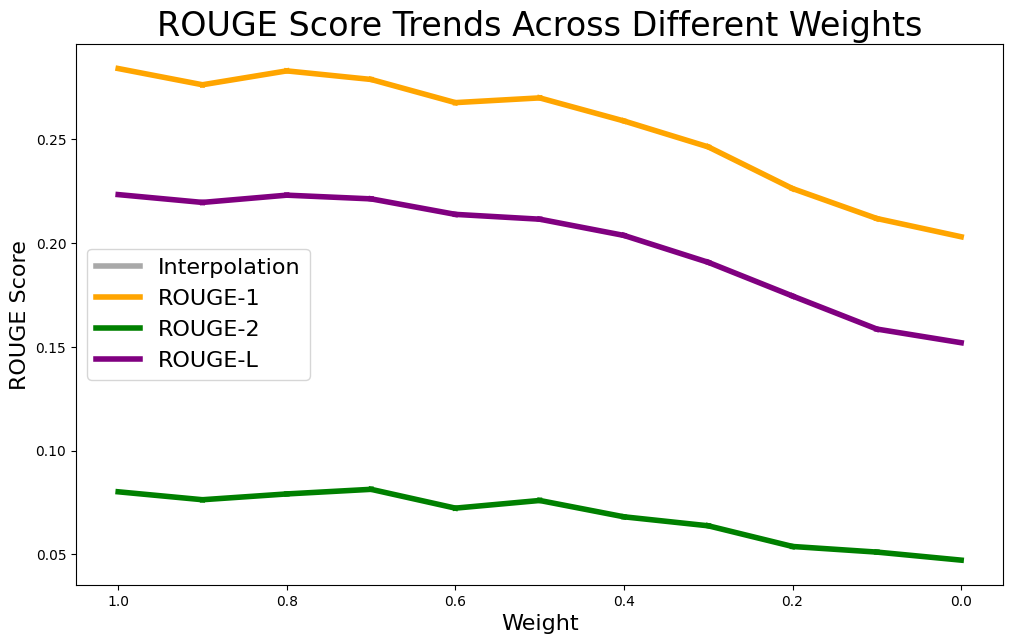

Shorter Model
Rouge-1: 0.2840458694405149
Rouge-2: 0.08010906672359965
Rouge-L: 0.22330192270977023
Longer Model
Rouge-1: 0.2029851769229102
Rouge-2: 0.04717627469503244
Rouge-L: 0.15193144517471885


In [56]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Shortest - Long

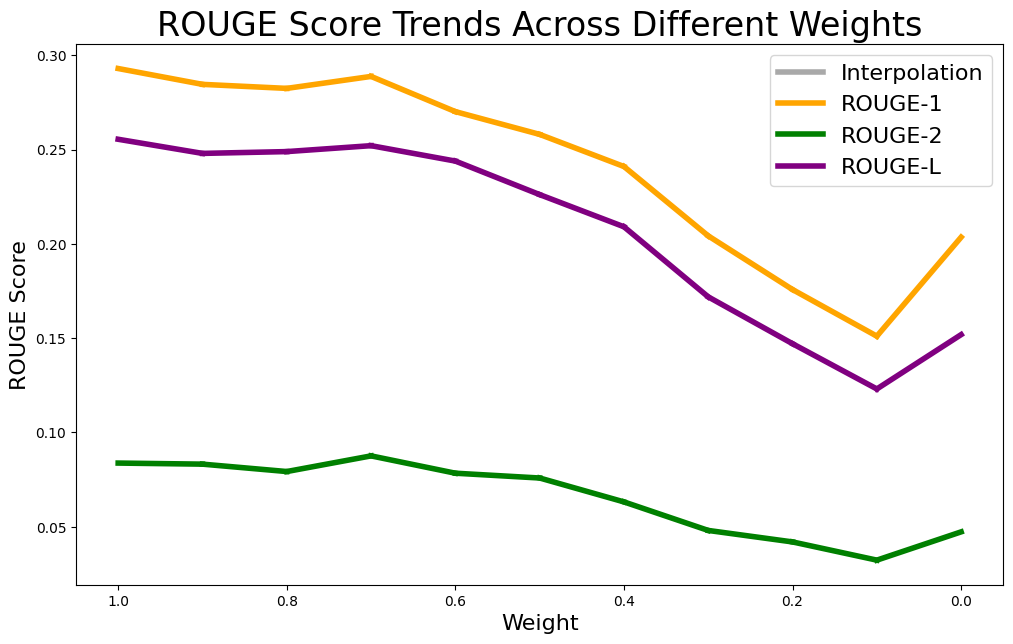

Shorter Model
Rouge-1: 0.29294906940079735
Rouge-2: 0.08370748672343475
Rouge-L: 0.2554312421563792
Longer Model
Rouge-1: 0.20351829249860753
Rouge-2: 0.04723051738799086
Rouge-L: 0.15184138272264291


In [57]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Short - Long (low var)

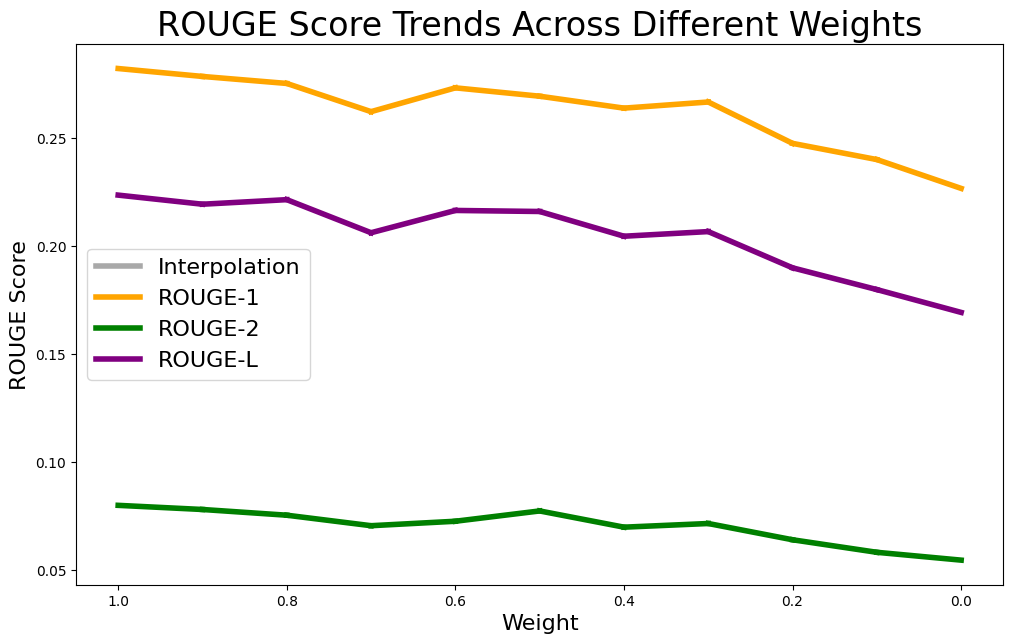

Shorter Model
Rouge-1: 0.2823291755697427
Rouge-2: 0.08014744374577959
Rouge-L: 0.223739601625841
Longer Model
Rouge-1: 0.22683623032794242
Rouge-2: 0.05478391071419366
Rouge-L: 0.16944100991356725


In [58]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if gen['idx'] < 500
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

## Longer Test Set

### Short - Long (extrap)

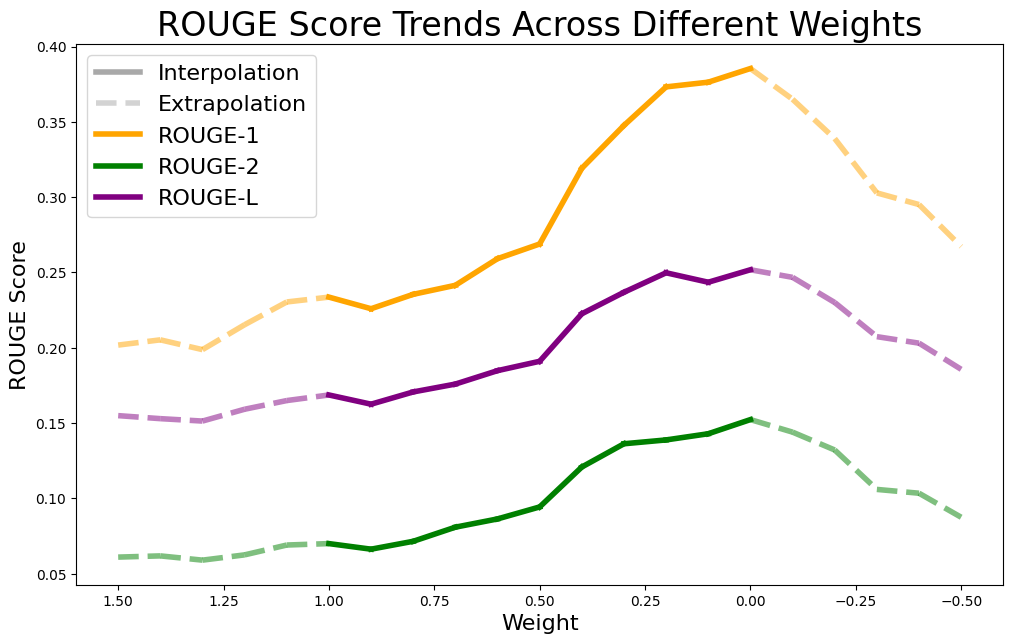

Shorter Model
Rouge-1: 0.2336242559066859
Rouge-2: 0.06998200904487198
Rouge-L: 0.1686601152206179
Longer Model
Rouge-1: 0.3853820843186678
Rouge-2: 0.15230881839991584
Rouge-L: 0.2517848961714894


In [59]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_deamp_weights
    ]
)

### Short - Long

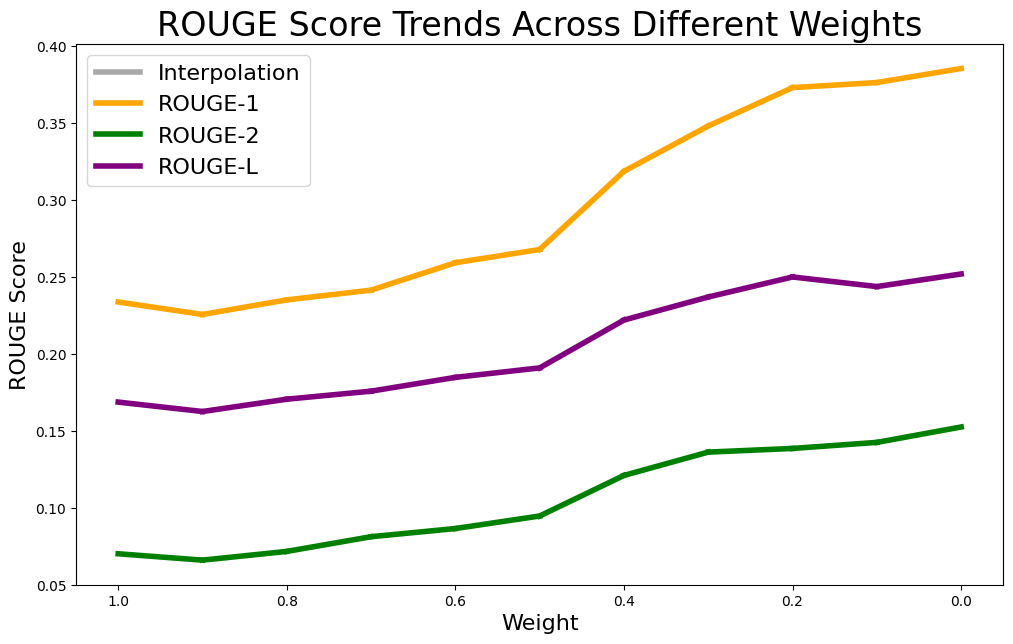

Shorter Model
Rouge-1: 0.23377265467934205
Rouge-2: 0.07005786664241578
Rouge-L: 0.16868031608042033
Longer Model
Rouge-1: 0.38557521947768814
Rouge-2: 0.15250072507957818
Rouge-L: 0.2519920313201678


In [60]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Shortest - Long

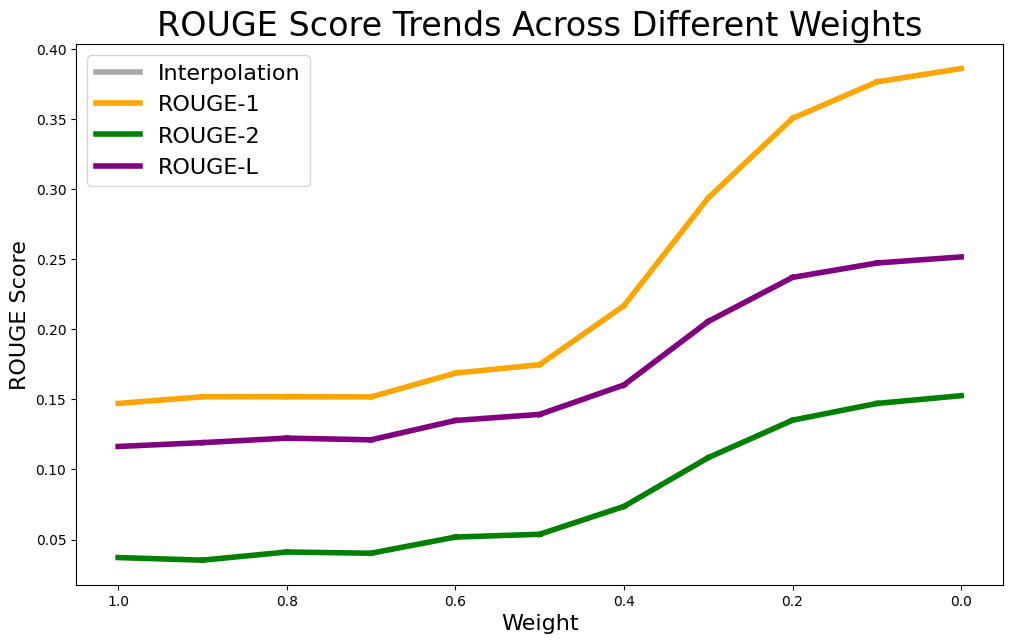

Shorter Model
Rouge-1: 0.14710416536680349
Rouge-2: 0.03715666967511283
Rouge-L: 0.11639746988469268
Longer Model
Rouge-1: 0.38604564768058236
Rouge-2: 0.1526410731439866
Rouge-L: 0.2516320276610663


In [61]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Short - Long (low var)

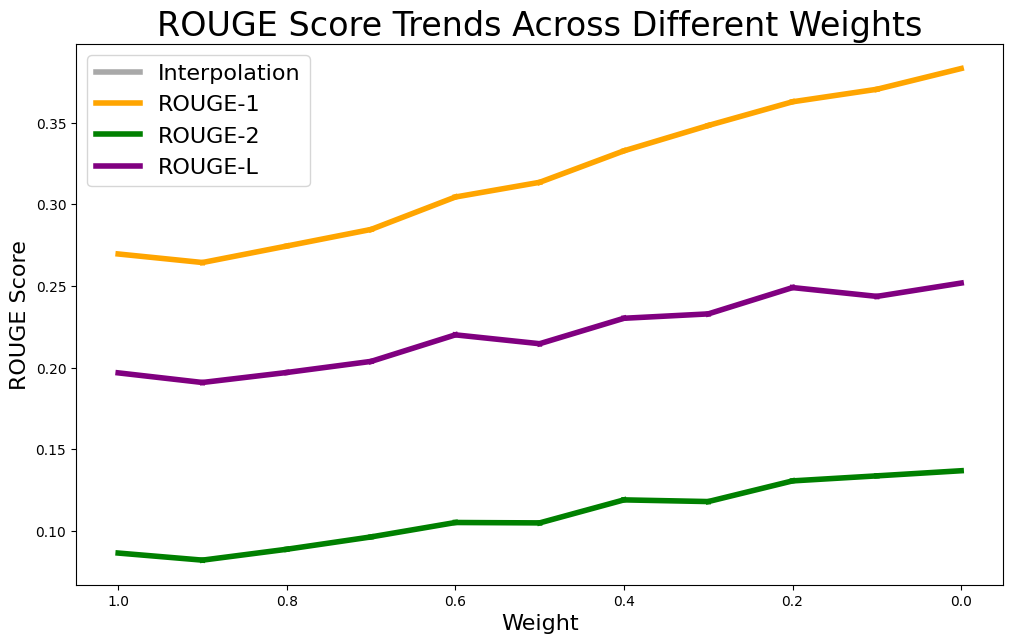

Shorter Model
Rouge-1: 0.2696796276791599
Rouge-2: 0.08640463227840633
Rouge-L: 0.19682785790907353
Longer Model
Rouge-1: 0.38331888397445274
Rouge-2: 0.13683930519677082
Rouge-L: 0.25185324089875094


In [62]:
plot_both_rouge(
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gen['target'])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if gen['idx'] >= 500
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

## Gold Test Set

In [63]:
def clean(inp):
    # only keep alphanumeric characters
    inp = ''.join(e for e in inp if e.isalnum() or e.isspace())
    # remove multiple spaces
    inp = ' '.join(inp.split())
    inp = inp.lower()
    return inp

def remove_summ_inst(prompt):
    return clean(prompt.split('Summarize the following text:\n')[-1])

# traverse everything inside gold_data

def update_mapping(gold_data_dict, map_dct):
    if isinstance(gold_data_dict, dict):
        keys = gold_data_dict.keys()
        if len(keys) == 2 and 'input' in keys and 'target' in keys:
            map_dct[clean(gold_data_dict['input'])] = gold_data_dict['target']
        else:
            for key in keys:
                update_mapping(gold_data_dict[key], map_dct)
    elif isinstance(gold_data_dict, list):
        for item in gold_data_dict:
            update_mapping(item, map_dct)
    else:
        raise ValueError("Invalid data type")

In [64]:
gold_inp2target = {}
update_mapping(gold_data, gold_inp2target)

In [65]:
gold_xsum_inp2target = {}
update_mapping(gold_data['xsum'], gold_xsum_inp2target)

In [66]:
gold_cnndm_inp2target = {}
update_mapping(gold_data['cnndm'], gold_cnndm_inp2target)

### Full

#### Short - Long (extrap)

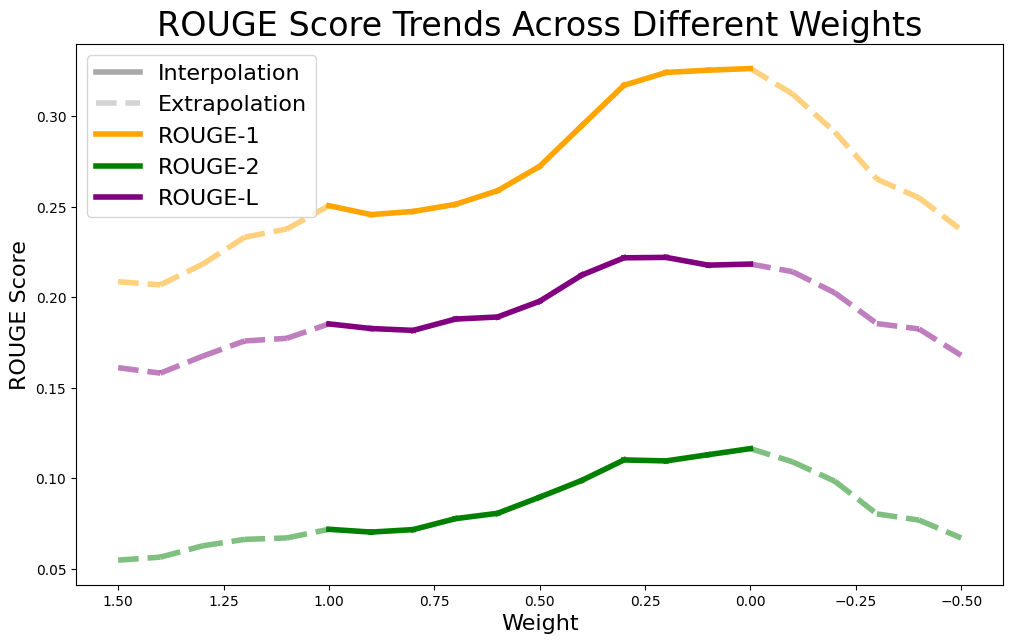

Shorter Model
Rouge-1: 0.2505435986850376
Rouge-2: 0.07179899511526523
Rouge-L: 0.18525113198988402
Longer Model
Rouge-1: 0.32630669540632345
Rouge-2: 0.11636315625512825
Rouge-L: 0.21830562915960106


In [67]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ]
)

#### Short - Long

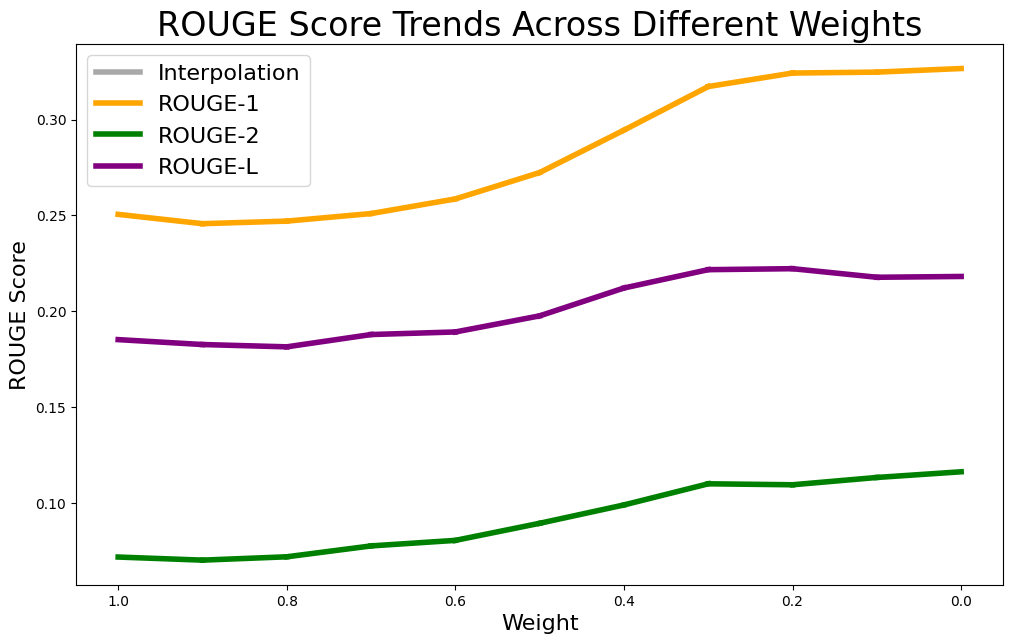

Shorter Model
Rouge-1: 0.25057282950712956
Rouge-2: 0.07185007993159911
Rouge-L: 0.1852485198562991
Longer Model
Rouge-1: 0.3266352726678303
Rouge-2: 0.11632145755840995
Rouge-L: 0.2181822283461692


In [68]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Shortest - Long

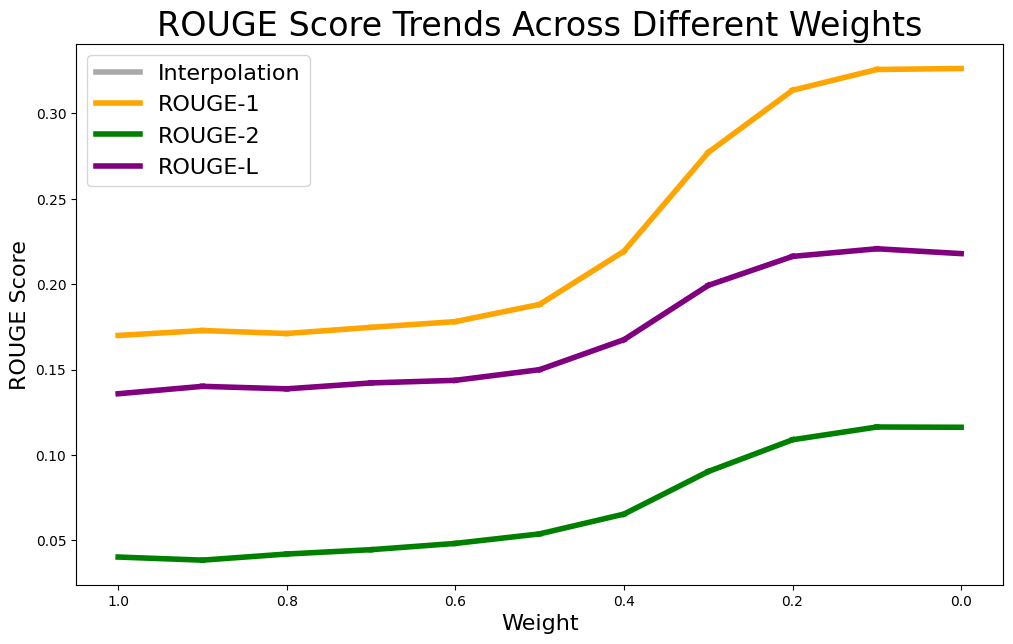

Shorter Model
Rouge-1: 0.16995279089213566
Rouge-2: 0.04016867685803684
Rouge-L: 0.135804530299324
Longer Model
Rouge-1: 0.3262984087258126
Rouge-2: 0.11617561759468192
Rouge-L: 0.21788952518161953


In [69]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Short - Long (low var)

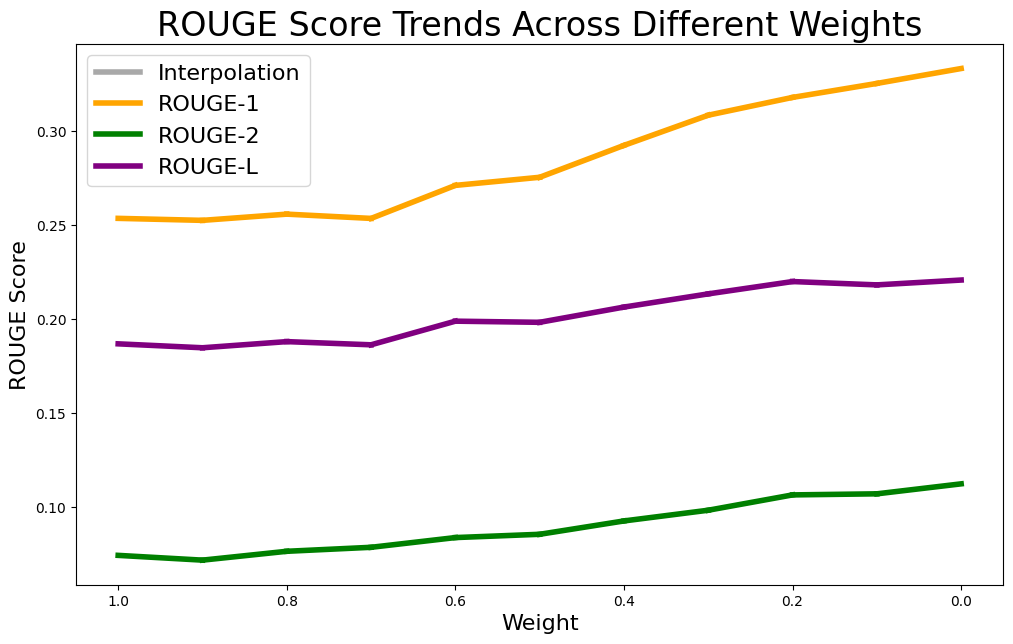

Shorter Model
Rouge-1: 0.25337619779369924
Rouge-2: 0.07422898506142461
Rouge-L: 0.18667414852701916
Longer Model
Rouge-1: 0.3330261160496427
Rouge-2: 0.11224959988821319
Rouge-L: 0.22058805576088958


In [70]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Xsum

#### Short - Long (extrap)

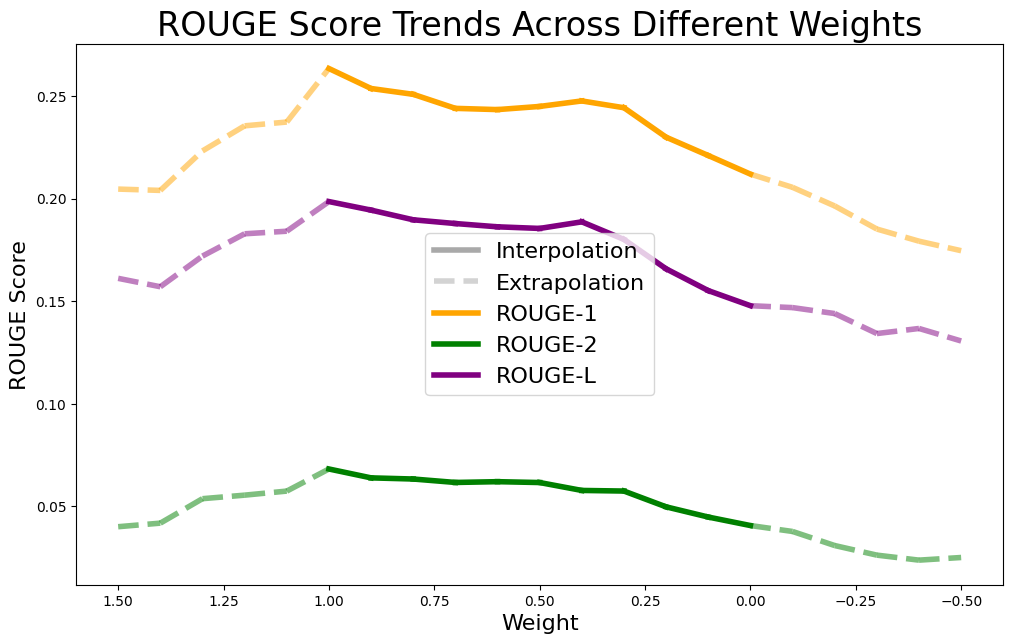

Shorter Model
Rouge-1: 0.26335698485869924
Rouge-2: 0.06823830106280931
Rouge-L: 0.1985326947736854
Longer Model
Rouge-1: 0.2119122278112982
Rouge-2: 0.04068679756218911
Rouge-L: 0.14780302594933697


In [71]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_deamp_weights
    ]
)

#### Short - Long

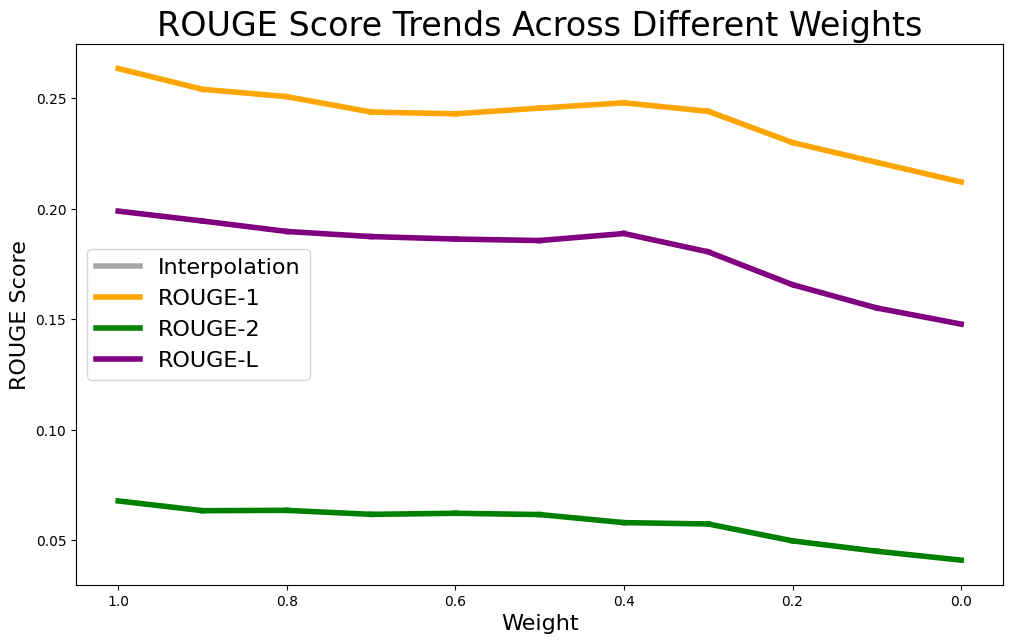

Shorter Model
Rouge-1: 0.2634799489651958
Rouge-2: 0.06783160201408048
Rouge-L: 0.1989646077873814
Longer Model
Rouge-1: 0.21215631794085588
Rouge-2: 0.041031377306725125
Rouge-L: 0.14782973390843437


In [72]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Shortest - Long

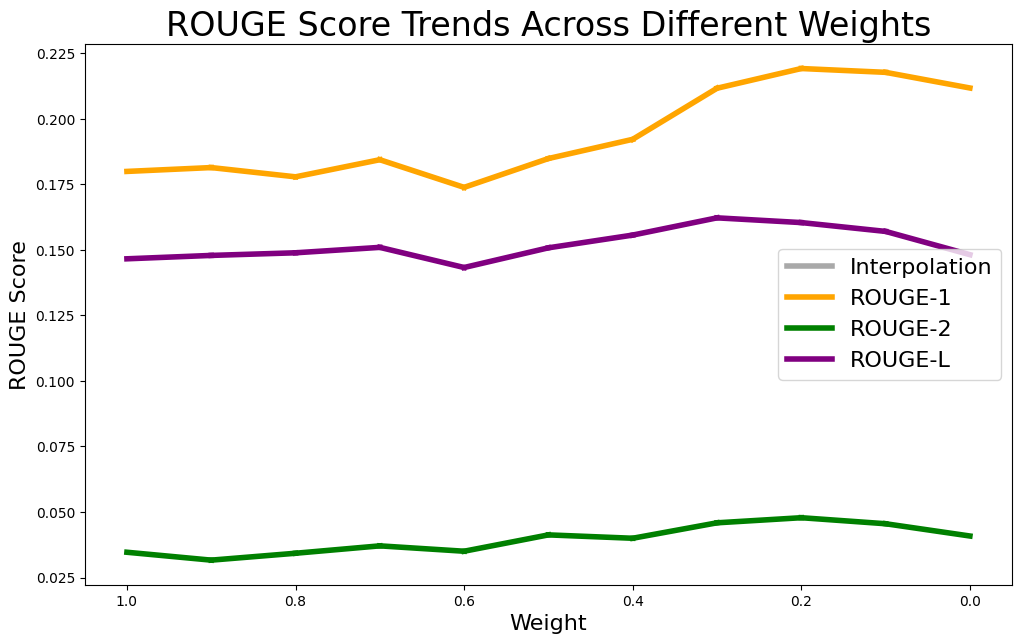

Shorter Model
Rouge-1: 0.17997027614577105
Rouge-2: 0.03463736091329829
Rouge-L: 0.14662347622044802
Longer Model
Rouge-1: 0.211807366496313
Rouge-2: 0.040837219135164714
Rouge-L: 0.14820353770722333


In [73]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Short - Long (low var)

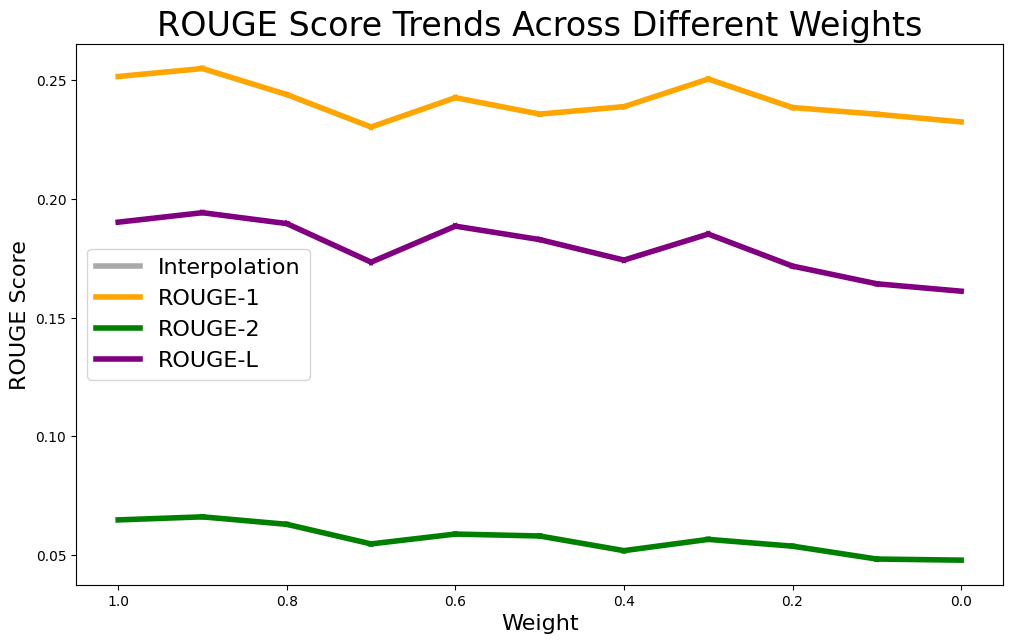

Shorter Model
Rouge-1: 0.25157152680735767
Rouge-2: 0.06485793612671126
Rouge-L: 0.19023374691366957
Longer Model
Rouge-1: 0.23245608076443544
Rouge-2: 0.047909424763502045
Rouge-L: 0.1611686159453253


In [74]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_xsum_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_xsum_inp2target
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

### Cnndm

#### Short - Long (extrap)

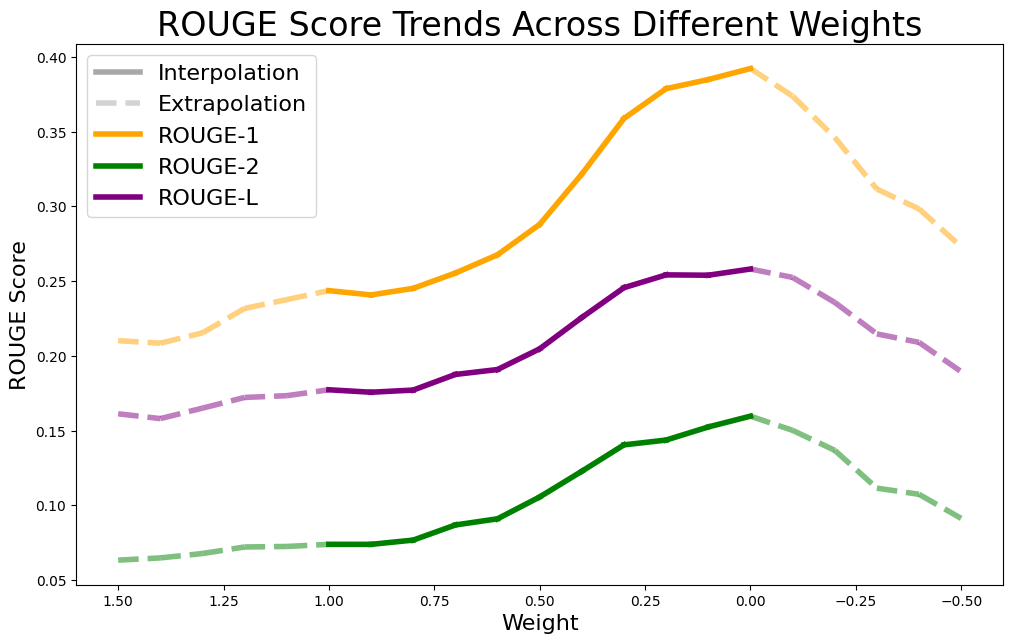

Shorter Model
Rouge-1: 0.24367264711035946
Rouge-2: 0.07397546531679026
Rouge-L: 0.17735654087512367
Longer Model
Rouge-1: 0.392235285174081
Rouge-2: 0.15969916459807404
Rouge-L: 0.2581299142666257


In [75]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_deamp_weights
    ]
)

#### Short - Long

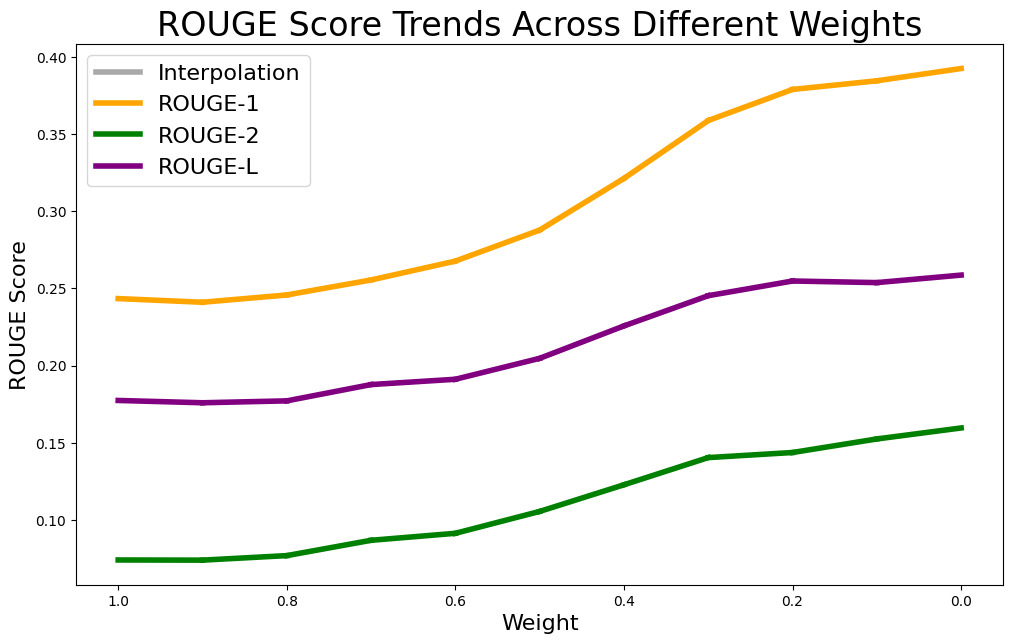

Shorter Model
Rouge-1: 0.2433638316494975
Rouge-2: 0.07403268632888596
Rouge-L: 0.17736471755303881
Longer Model
Rouge-1: 0.3924015586853473
Rouge-2: 0.1595531717788372
Rouge-L: 0.25858028741384836


In [76]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Shortest - Long

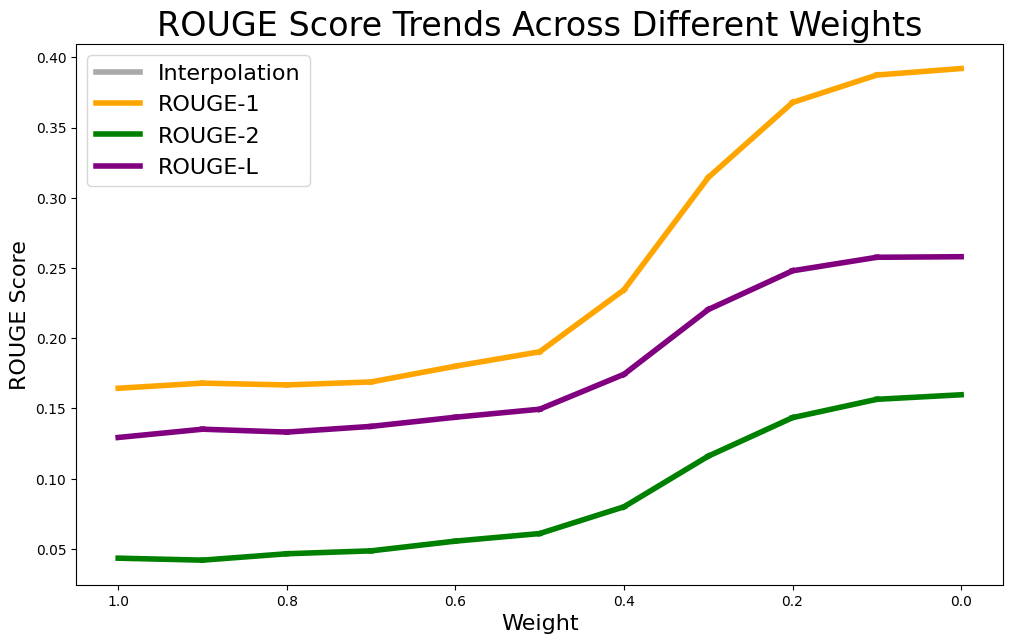

Shorter Model
Rouge-1: 0.16435107671274107
Rouge-2: 0.04333419688622336
Rouge-L: 0.12929859270922178
Longer Model
Rouge-1: 0.3920832025604314
Rouge-2: 0.15972429788199743
Rouge-L: 0.2580521407255546


In [77]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['shortest_long']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

#### Short - Long (low var)

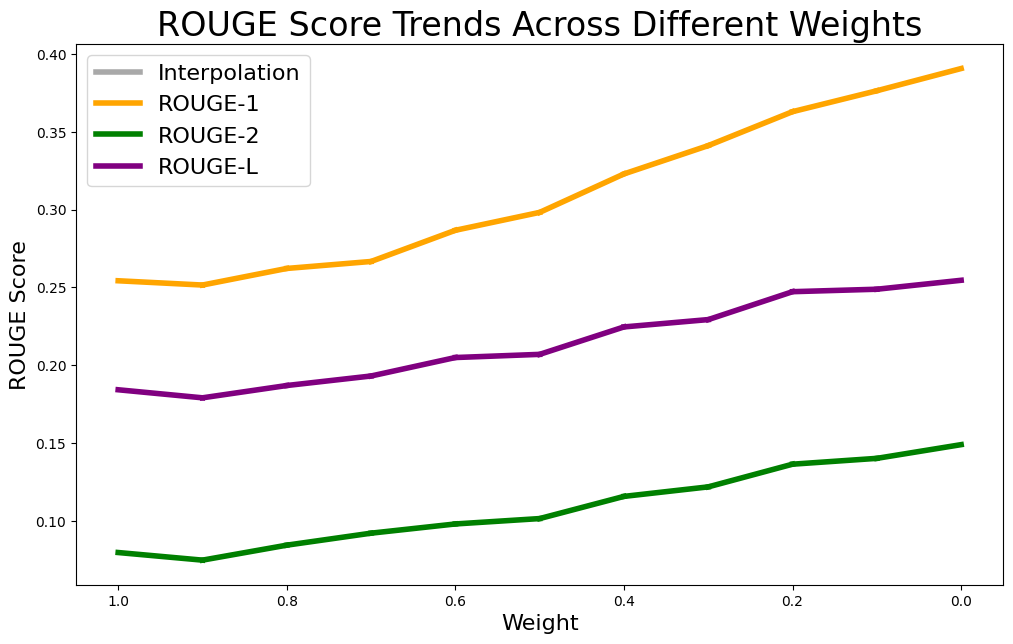

Shorter Model
Rouge-1: 0.2542547555838246
Rouge-2: 0.07956421057892599
Rouge-L: 0.1841915298056941
Longer Model
Rouge-1: 0.39068668527130385
Rouge-2: 0.1489171646429533
Rouge-L: 0.2545698618915133


In [78]:
plot_both_rouge(
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in interp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_amp_weights
    ],
    [
        [
            (gen['generated'], gold_cnndm_inp2target[remove_summ_inst(gen['prompt'])])
            for gen in gens['short_long_low_var']['both']['linear'][weight]
            if remove_summ_inst(gen['prompt']) in gold_cnndm_inp2target
        ]
        for weight in extrap_deamp_weights
    ],
    extrap=False
)

# Qualitative Analysis

In [79]:
def get_one(prior_idx=None):
    gen_data = gens['short_long']['both']['linear']
    if prior_idx is None:
        rand_idx = random.randint(0, len(gen_data[0]) - 1)
    else:
        rand_idx = prior_idx

    print(f"Index: {rand_idx}")
    print("Prompt:")
    print(f"{gen_data[0][rand_idx]['prompt']}")
    print()

    tgt = gold_inp2target[remove_summ_inst(gen_data[0][rand_idx]['prompt'])]
    print(f"Target (len = {len(tgt)}):")
    print(f"{tgt}")
    print()

    for weight in interp_weights:
        print(f"Weight: {weight / 100} (len = {len(gen_data[weight][rand_idx]['generated'])})")
        print(f"{gen_data[weight][rand_idx]['generated']}")
        print()

In [80]:
"""
Removing 1 outliers.
the indices are (array([234]),)
Removing 1 outliers.
the indices are (array([493]),)
Removing 0 outliers.
the indices are (array([], dtype=int64),)
Removing 1 outliers.
the indices are (array([585]),)
Removing 1 outliers.
the indices are (array([538]),)
Removing 1 outliers.
the indices are (array([603]),)
Removing 2 outliers.
the indices are (array([524, 572]),)
Removing 3 outliers.
the indices are (array([ 62, 617, 628]),)
Removing 1 outliers.
the indices are (array([640]),)
Removing 1 outliers.
the indices are (array([165]),)
Removing 3 outliers.
the indices are (array([ 58, 133, 320]),)
"""

'\nRemoving 1 outliers.\nthe indices are (array([234]),)\nRemoving 1 outliers.\nthe indices are (array([493]),)\nRemoving 0 outliers.\nthe indices are (array([], dtype=int64),)\nRemoving 1 outliers.\nthe indices are (array([585]),)\nRemoving 1 outliers.\nthe indices are (array([538]),)\nRemoving 1 outliers.\nthe indices are (array([603]),)\nRemoving 2 outliers.\nthe indices are (array([524, 572]),)\nRemoving 3 outliers.\nthe indices are (array([ 62, 617, 628]),)\nRemoving 1 outliers.\nthe indices are (array([640]),)\nRemoving 1 outliers.\nthe indices are (array([165]),)\nRemoving 3 outliers.\nthe indices are (array([ 58, 133, 320]),)\n'